# Introduction

In order to optimize marketing campaigns with the help of the dataset, we will have to take the following steps:

1. Import data from dataset and perform initial high-level analysis: look at the number of rows, look at the missing values, look at dataset columns and their values respective to the campaign outcome.
2. Clean the data: remove irrelevant columns, deal with missing and incorrect values, turn categorical columns into dummy variables.
3. Use machine learning techniques to predict the marketing campaign outcome and to find out factors, which affect the success of the campaign.

**This dataset is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit.**

**features explanation**: 

1 - **age** (numeric)

2 - **job**: type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                   "blue-collar","self-employed","retired","technician","services") 
                                   
3 - **marital** : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed

4 - **education** (categorical: "unknown","secondary","primary","tertiary")

5 - **default**: has credit in default? (binary: "yes","no")

6 - **balance**: average yearly balance, in euros (numeric) 

7 - **housing**: has housing loan? (binary: "yes","no")

8 - **loan**: has personal loan? (binary: "yes","no")

**related with the last contact of the current campaign**:
9 - **contact**: contact communication type (categorical: "unknown","telephone","cellular") 

10 - **day**: last contact day of the month (numeric)

11 - **month**: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

12 - **duration**: last contact duration, in seconds (numeric)


**other attributes**:

13 - **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - **previous**: number of contacts performed before this campaign and for this client (numeric)

16 - **poutcome**: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

**Output variable (desired target)**:

17 - y - has the client subscribed a term deposit? (binary: "yes","no")




In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro,mannwhitneyu
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
import xgboost as xgb
import lightgbm as lgb

In [107]:
df = pd.read_csv('bank.csv')
df_copy = df.copy()
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

# **data preprocessing- EDA**

### null and unique values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [4]:
def report_table(dataset):
        dtypes=dataset.dtypes
        nulls = dataset.isnull().sum()
        per = nulls/dataset.isnull().count()*100
        nunique = dataset.nunique()
        df_type_nulls =pd.concat([dtypes, nulls,per, nunique], axis=1)
        df_type_nulls.rename(columns = {0: 'dtypes', 1: 'nulls',  2: 'nulls in percentage', 3:'uniques'}, inplace = True)
        
        return df_type_nulls

In [5]:
report_table(df)

dtypes  nulls  nulls in percentage  uniques
age         int64      0                  0.0       76
job        object      0                  0.0       12
marital    object      0                  0.0        3
education  object      0                  0.0        4
default    object      0                  0.0        2
balance     int64      0                  0.0     3805
housing    object      0                  0.0        2
loan       object      0                  0.0        2
contact    object      0                  0.0        3
day         int64      0                  0.0       31
month      object      0                  0.0       12
duration    int64      0                  0.0     1428
campaign    int64      0                  0.0       36
pdays       int64      0                  0.0      472
previous    int64      0                  0.0       34
poutcome   object      0                  0.0        4
deposit    object      0                  0.0        2

as we can see, there are no null values. If there were missing values we will have to fill them with the median or mean. I tend to use the median but in this scenario there is no need to fill any missing values. This will definitely make our job easier!
we can also see that we have multiple list there are no features with only one value.

### label distribution

In [6]:
df.deposit.value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

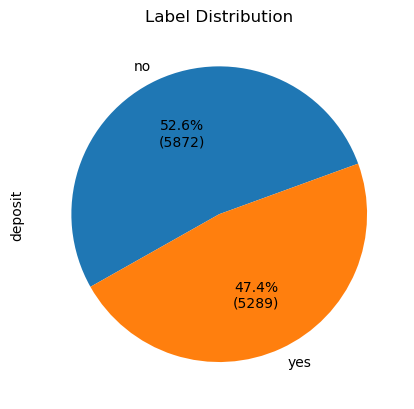

In [7]:
# Plot labels ditribution

# Get class counts and percentages
counts = df['deposit'].value_counts()
percentages = counts / counts.sum() * 100

# Plot pie chart
plt.title('Label Distribution')
counts.plot(kind='pie', autopct=lambda p: '{:.1f}%\n({:d})'.format(p, int(p * counts.sum() / 100)), startangle=20)

plt.show()

We can see that the classes distribution is very close, so we won't need to oversample/undesraple methods

## features exploration

I'll divide this section to 2 parts: numerical and categorical. afterwards, I'll try to show statistics combining both of them

### numerical features analysis

#### heatmap

now we'll see the correlations between the dataset features in order to see if there are features with high correlation

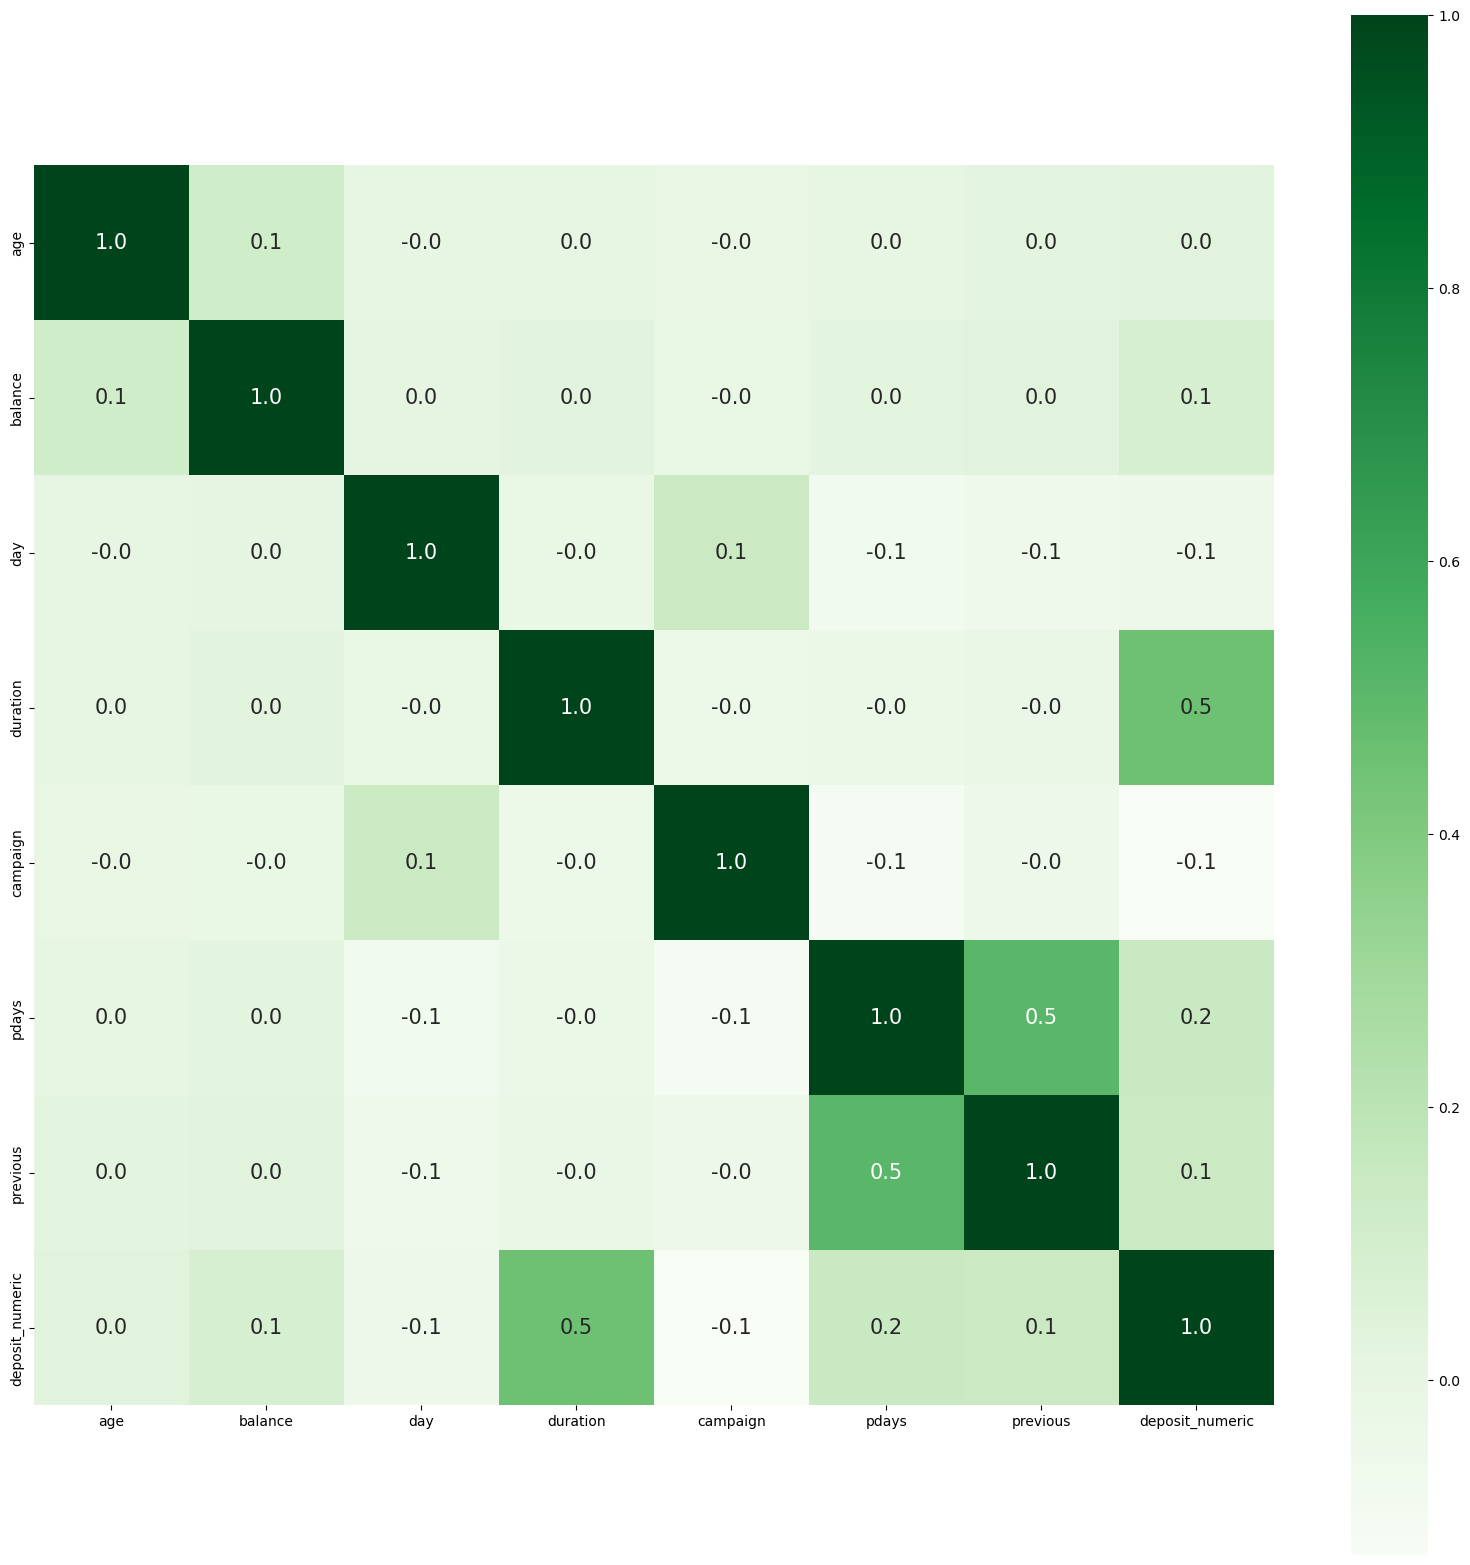

In [8]:
# Convert the deposit to numeric
df['deposit_numeric'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

# Plotting heatmap
plt.figure(figsize=(20,20))
corr = df.loc[:, df.dtypes!=object].corr()
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')
plt.show()

as we can see, there is no features who are very correlated with each other.
The only features that has correlation of 0.5 are:
1. duration-deposit: this might indicates that the longer the duration of the call, the more likely the customer will agree to open deposit, which make sense because they want to hear more details and negotiate on the conditions.
2. previous-pdays: not very high correlation, but might indicate on overlap between these 2 features, and we'll examine the connection between both of them later.

Now, let's view them by histograms

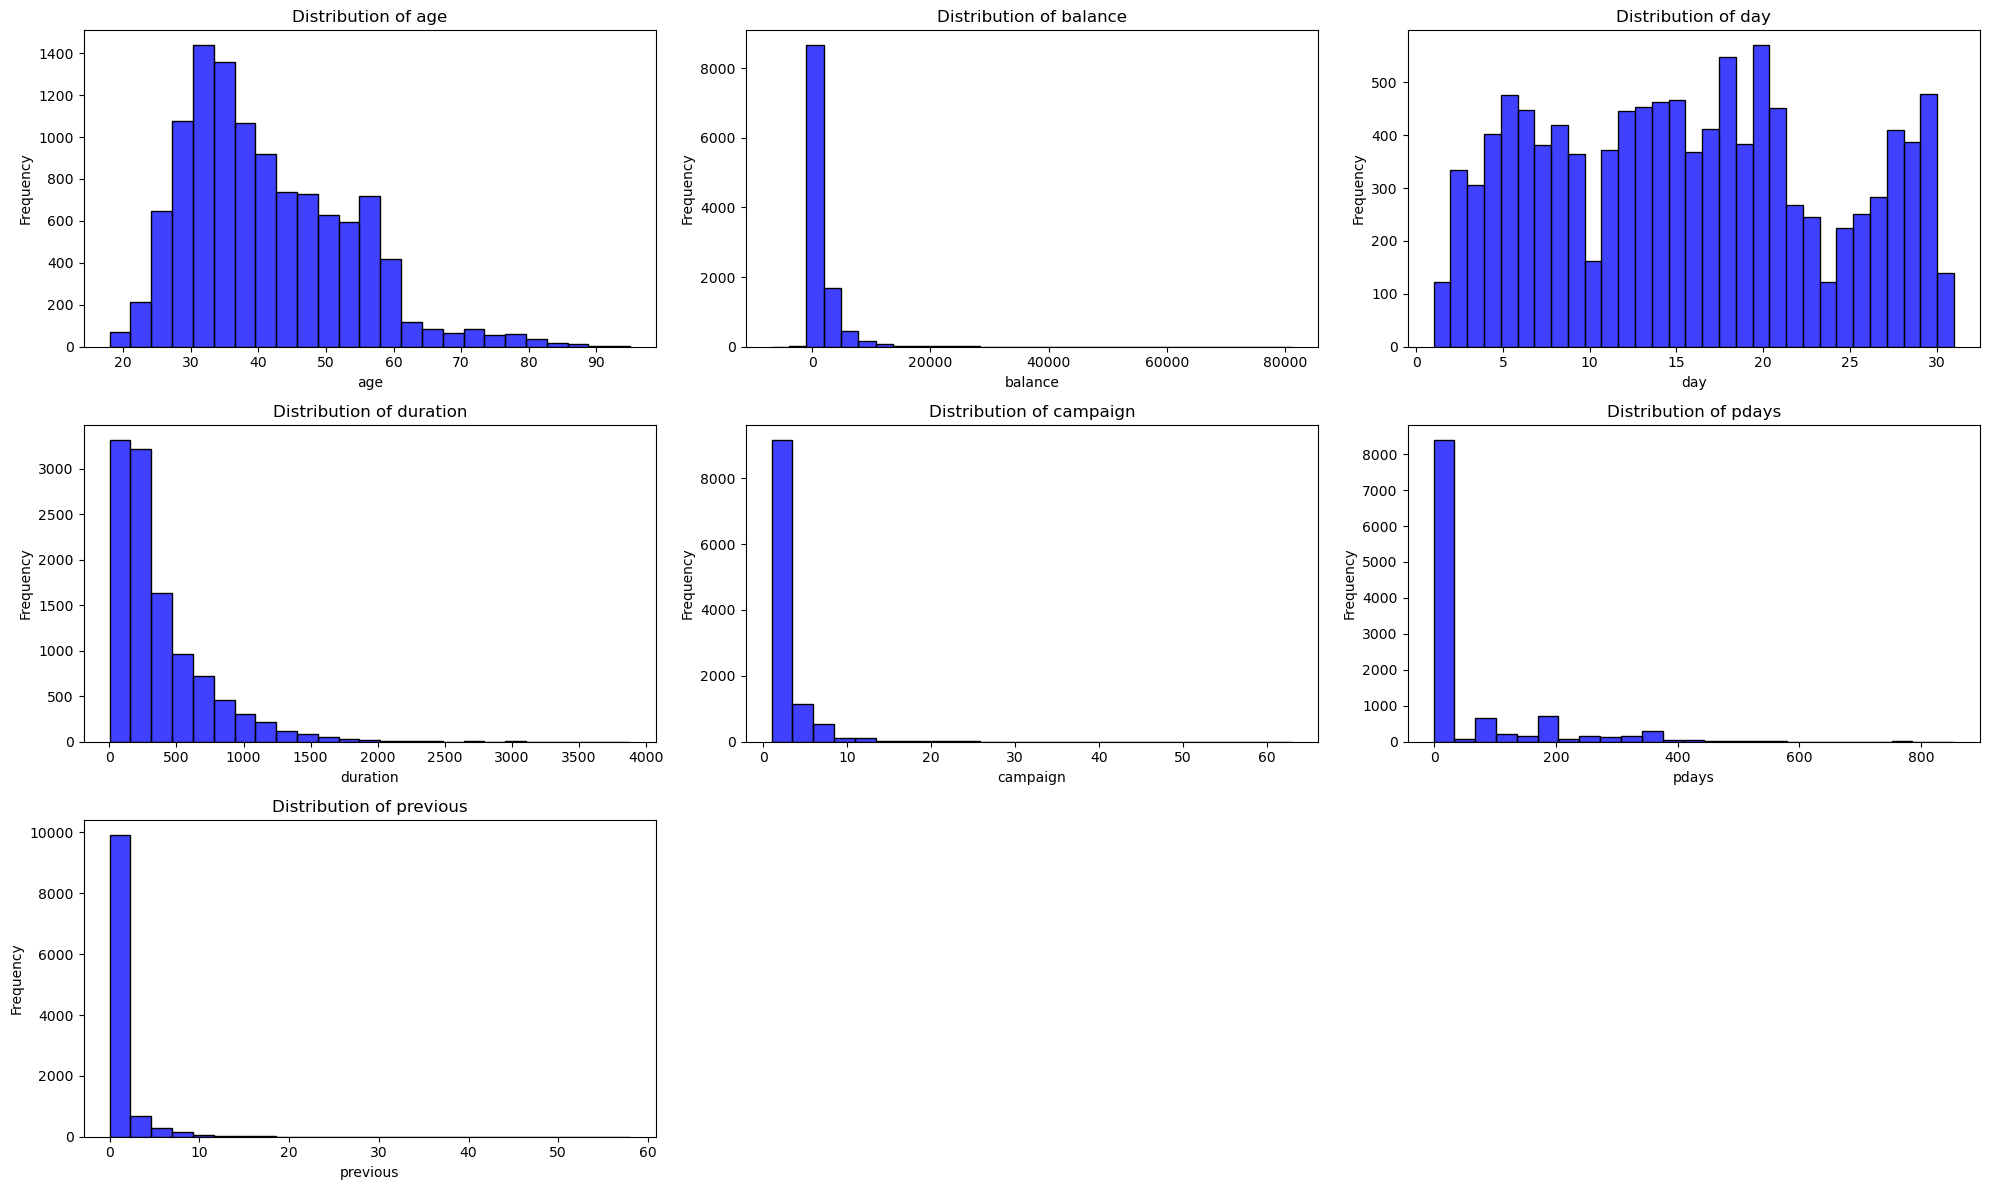

In [9]:
numeric_columns = ['age','balance','day','duration','campaign','pdays','previous']

# Define custom bin sizes for each column
custom_bins = {
    'age': 25,
    'balance': 30,
    'day': 31,
    'duration': 25,
    'campaign': 25,
    'pdays': 25,
    'previous': 25
}

# Set the size of the plots
plt.figure(figsize=(20, 12)) 

# Calculate number of rows and columns for the subplots
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # This ensures enough rows to handle all plots

# Loop through the numeric columns and create a histogram for each
for i, column in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i + 1)  # Arrange plots in a grid
    sns.histplot(df[column], kde=False, bins=custom_bins[column], color='blue')  # You can enable KDE for density estimation
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# Adjust the layout to make room for all subplots    
plt.tight_layout()  
plt.show()

We can see that most of the numerical columns have outliers (especially 'pdays', 'campaign' and 'previous' columns which we'll review later). There might be incorrect values (noisy data), and therefore we should look closer at the data.

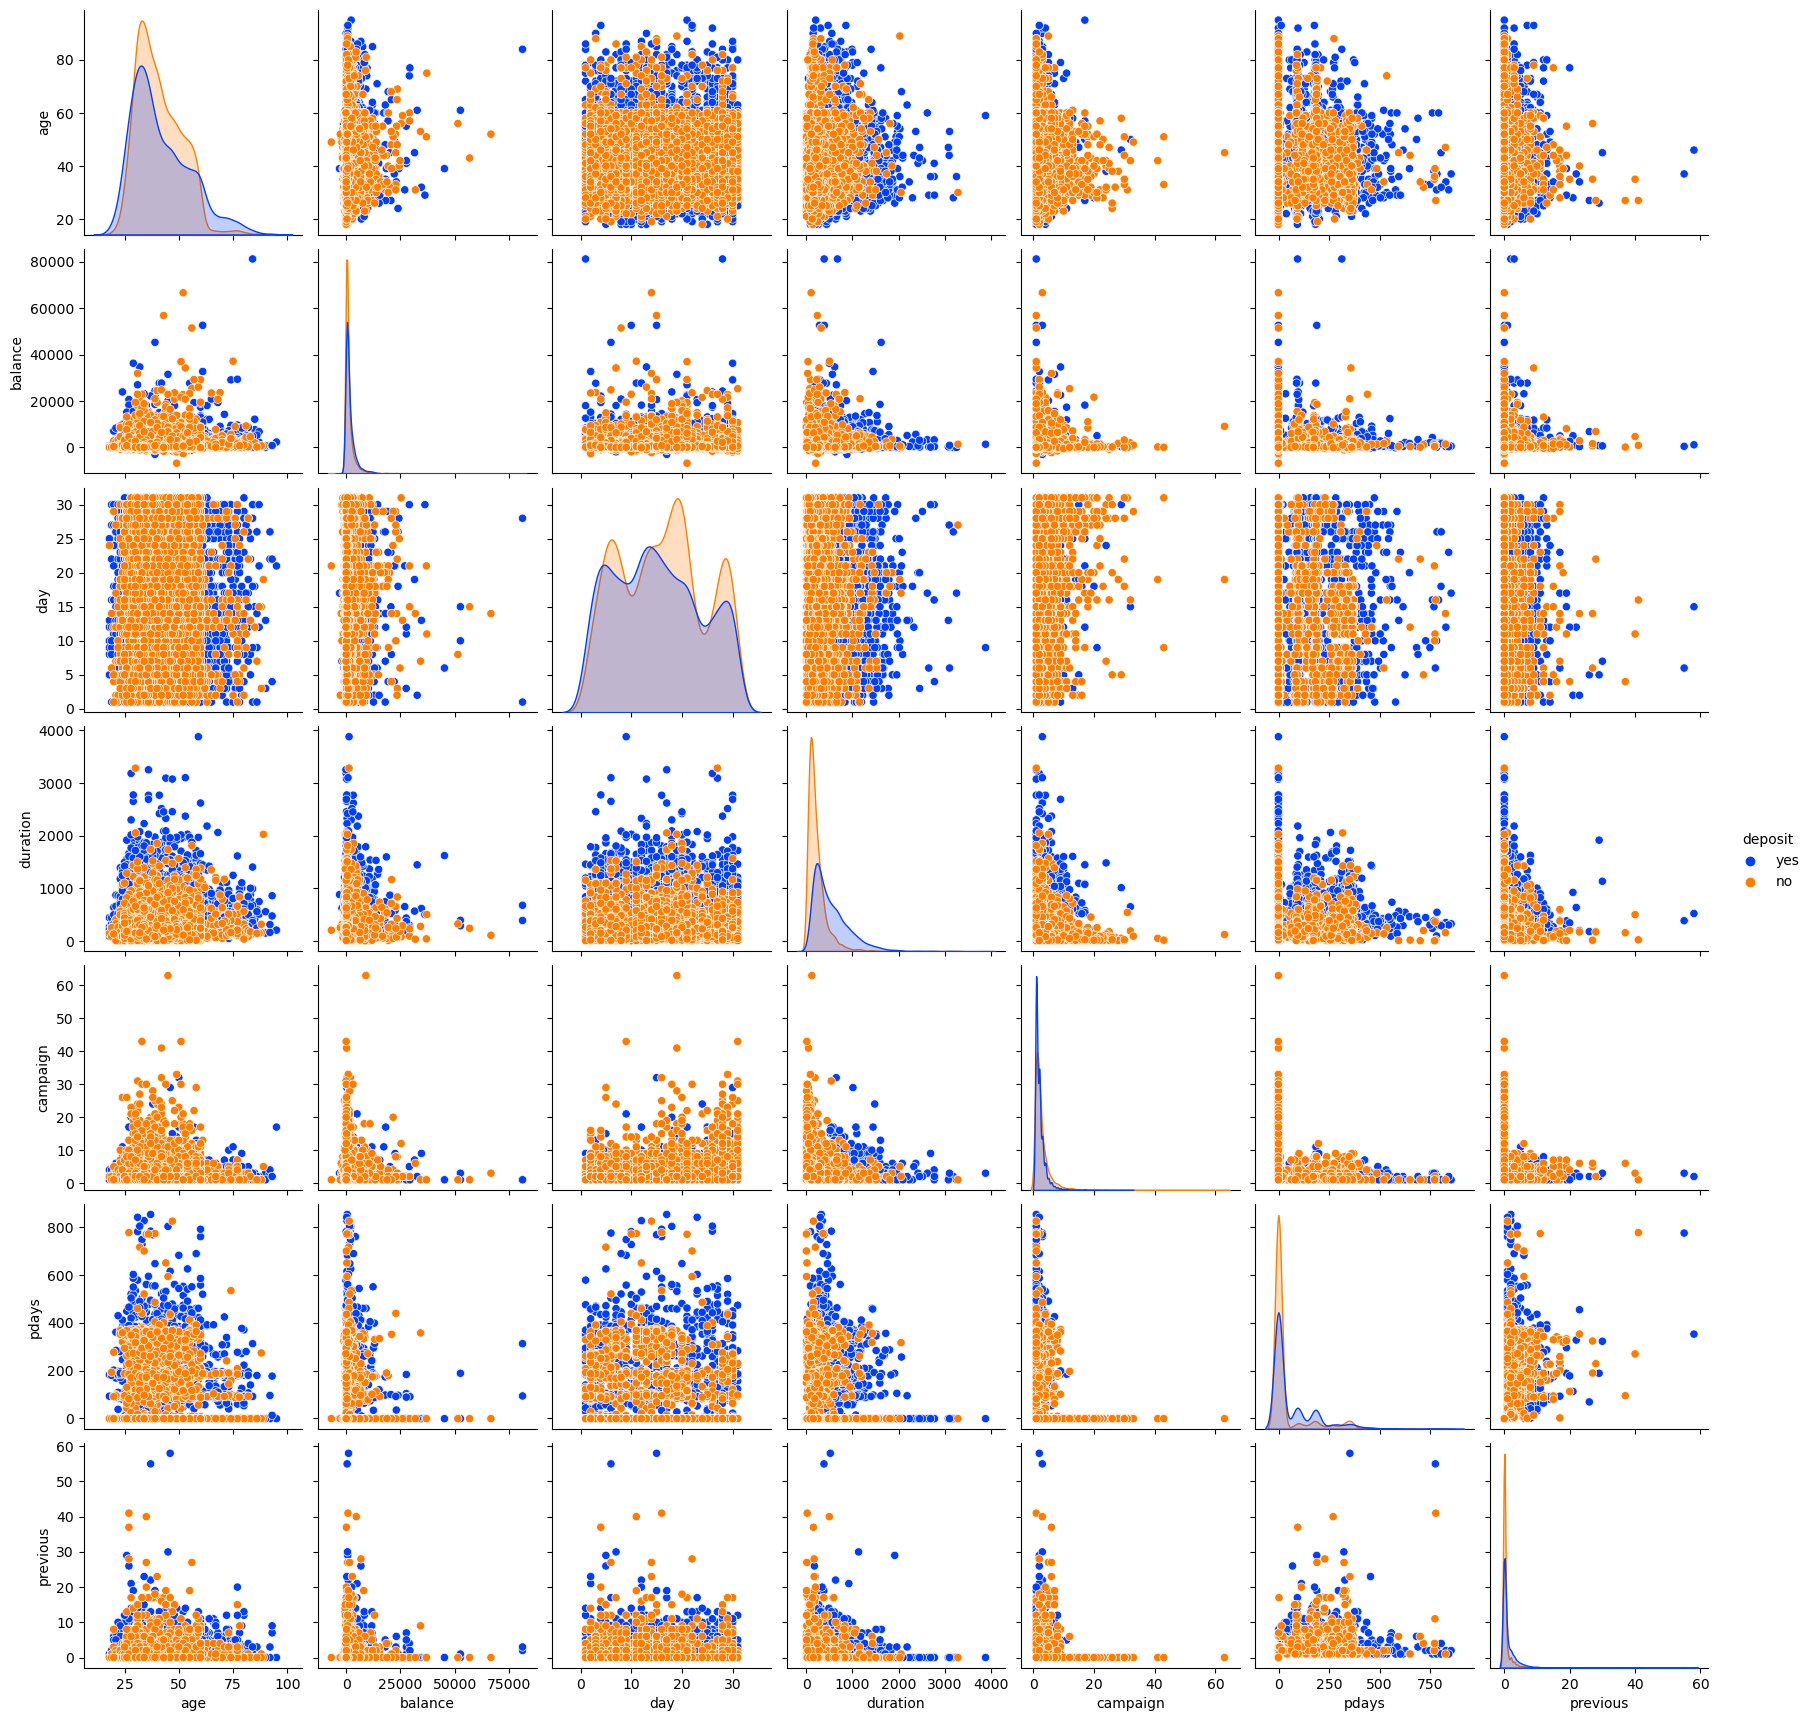

In [10]:
# List of numerical features
features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous','deposit']

sns.pairplot(df[features], hue='deposit', palette='bright')
plt.show()

It seems like there are interesting connections between features, for example about the duration or the day iteslf. It also seems that from the histograms that in some features we can see trends regarding the distribution to subscribe/unsubscribe to a term deposit, for example, in features duration and age.
we can see some connections trends in the pairplot that might help us in understanding the connections in the data, and we'll research it more later.

In [11]:
df.describe()

age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  deposit_numeric  
count  11162.000000  11162.000000     11162.000000  
mean      51.330407      0.832557         0.473840  
std      108.758282      2.292007         0.499338  
min       -1.000000      0.000000         0.000000  
25%       -1.000000      0.000000         0.000000  
50%       -1.000000      0.000000         0.000000  
75%       20.750000      1.000000         1.000000  
max      854.000000     58.000000         1.000000

#### Summary

There are few insights about the numerical features:
1. age- the range is between 18-95 and the mean is 41. the retirement age in Portugal is 66 and we can see from the data that the majority of the calls that has been doNe was to people who are less than 60. It might indicate that the bank thought that elderly people are more likely not to open a deposit.
2. balance- the range is between -6847-81204 and the mean is 1528. the std is high and it indicates that the data is more spread outlarge over the dataset. This feature might be important because a higher average yearly balance might indicate more disposable income available for investments like term deposits 
3. duration- the range is between 2-3881 seconds and the mean is 371 seconds (6 minutes). this feature might also be important since longer call durations might indicate higher interest or more effective persuasion by the marketer.
Let's analyze these 3 features.

Let's view the next fetures: age, balance, duration

#### Feature: age

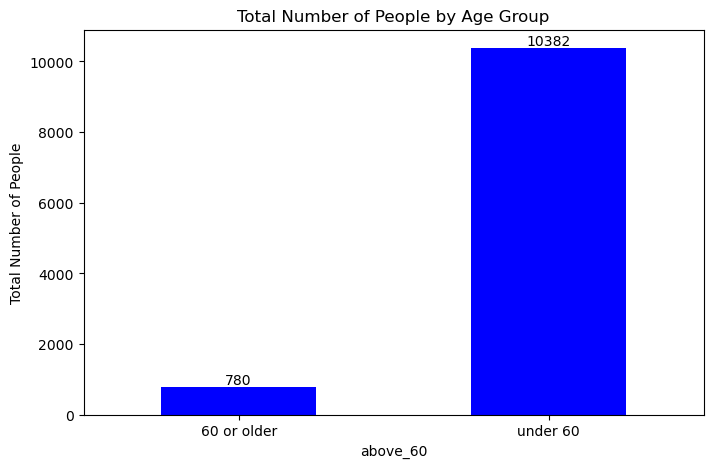

In [12]:
# Create a new column for age by group of above/under 60
df['above_60'] = df['age'].apply(lambda x: '60 or older' if x >= 60 else 'under 60')

# Calculate the total counts for each age group
total_counts = df.groupby('above_60').size()

# Plot bar chart
ax = total_counts.plot(kind='bar', color='blue', figsize=(8, 5))
plt.ylabel('Total Number of People')
plt.title('Total Number of People by Age Group')
plt.xticks(rotation=0)

# Adding data texts to the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.show()

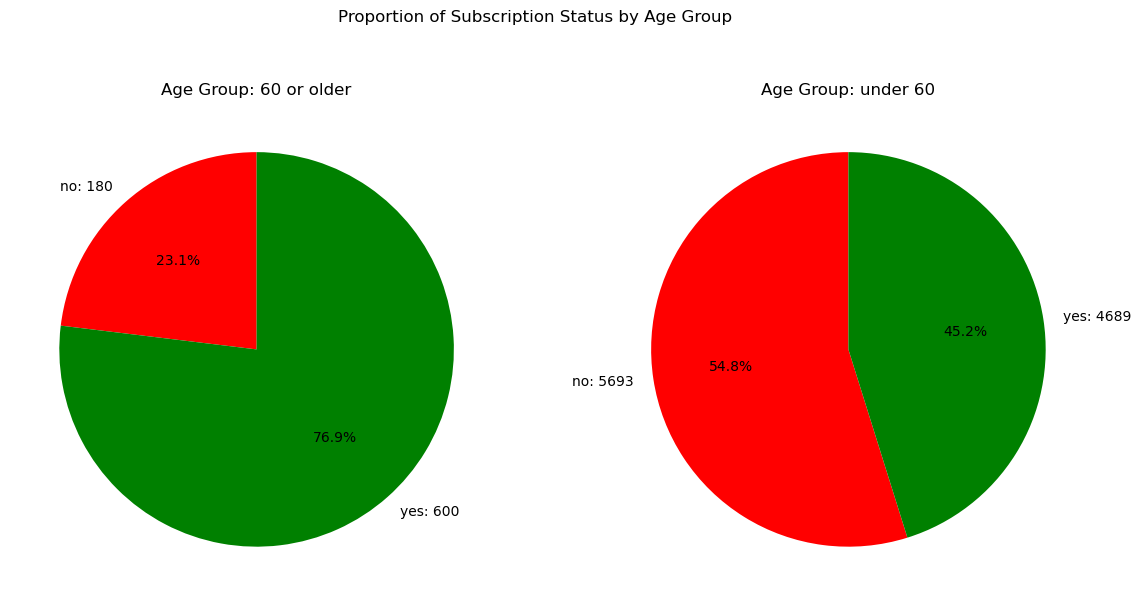

In [13]:
grouped = df.groupby(['above_60', 'deposit']).size().unstack(fill_value=0)

# Creating enhanced pie charts for each group
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for i, (idx, row) in enumerate(grouped.iterrows()):
    axes[i].pie(row, labels=[f'{label}: {val}' for label, val in row.items()],
                autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
    axes[i].set_title(f'Age Group: {idx}')

plt.suptitle('Proportion of Subscription Status by Age Group')
plt.show()

We see that although people aged 60+ were sampled less, the success rate for opening a deposit is higher. It might have several explanations, such as when people are closer to retirement they would like to save money as possible. This feature may be significant in the model we would like to build

#### Feature: balance

first, let's describe it

In [14]:
df['balance'].describe()

count    11162.000000
mean      1528.538524
std       3225.413326
min      -6847.000000
25%        122.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

In [15]:
grouped_stats = df.groupby('deposit')['balance'].agg(['mean', 'median']).reset_index()
grouped_stats

deposit         mean  median
0      no  1280.227141   414.0
1     yes  1804.267915   733.0

we can see that the mean and median are higher for people who subscribe for deposit and it might be a good indication to subscribe to one based on this feature. Let's proceed with the analysis

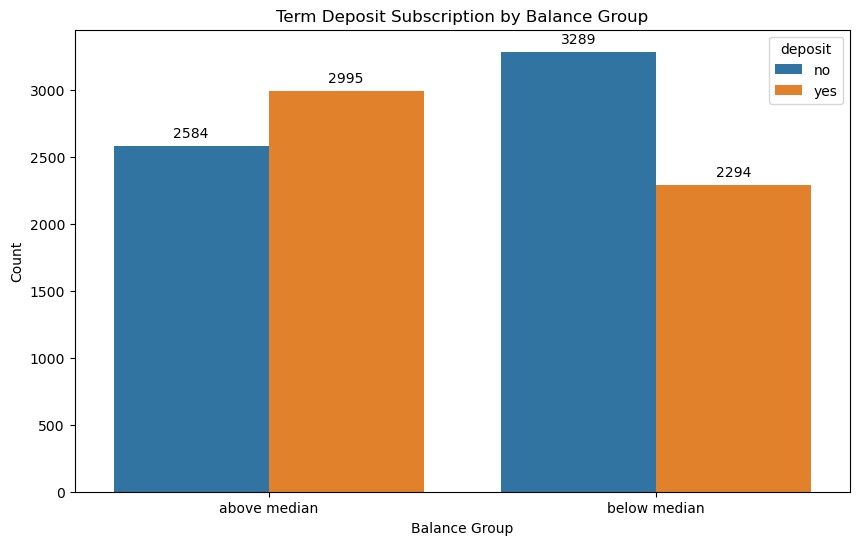

In [16]:
# Calculate the mean and median of the balance feature
median_balance = df['balance'].median()

# Choose whether to use mean or median
balance_threshold = median_balance

# Create a new column for balance split
df['balance_group'] = df['balance'].apply(lambda x: 'above median' if x > balance_threshold else 'below median')

# Group by the new column and the deposit
balance_group_counts = df.groupby(['balance_group', 'deposit']).size().reset_index(name='count')


plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='balance_group', y='count', hue='deposit', data=balance_group_counts)
plt.title('Term Deposit Subscription by Balance Group')
plt.xlabel('Balance Group')
plt.ylabel('Count')

# Add the text (count) above each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.show()

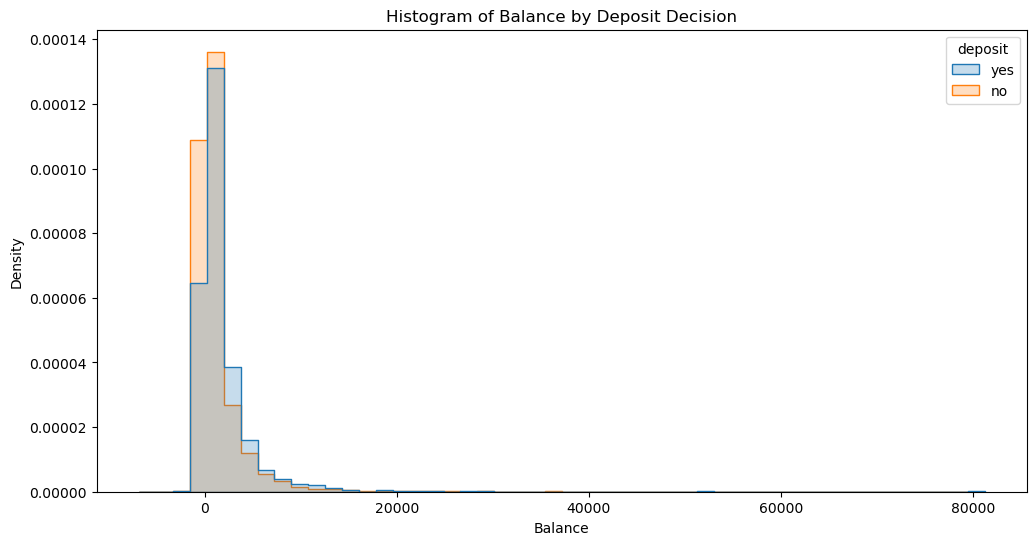

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='balance', hue='deposit', bins=50, kde=False, element='step', stat='density')
plt.xlabel('Balance')
plt.ylabel('Density')
plt.title('Histogram of Balance by Deposit Decision')
plt.show()

It seems at first sight that in general, the higher your balance, there is agreater chance a customer will subscribe for a deposit.

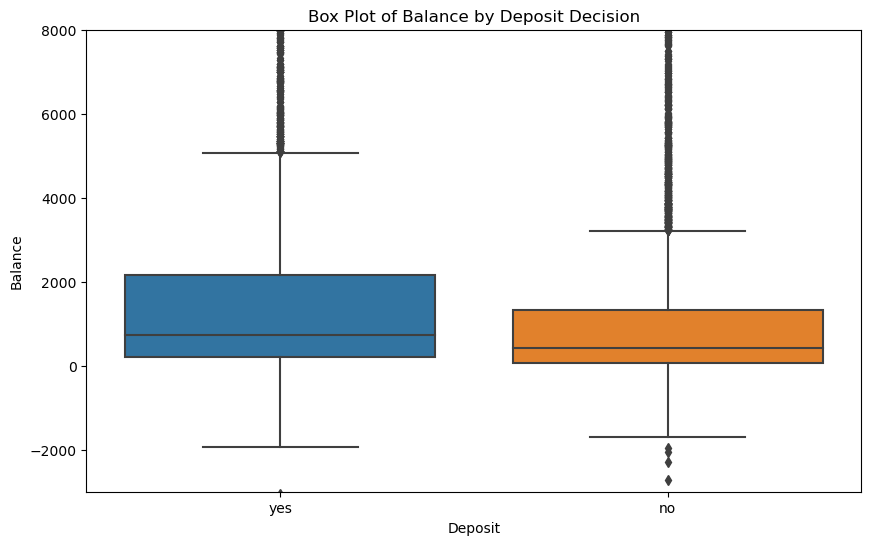

In [18]:
# Converting deposit to a numeric format for plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='deposit', y='balance', data=df)
plt.xlabel('Deposit')
plt.ylabel('Balance')
plt.ylim(-3000, 8000) 
plt.title('Box Plot of Balance by Deposit Decision')
plt.show()

I believe that the balance might be related to the next features: marital, education, job, default. let's review the connection between these features:

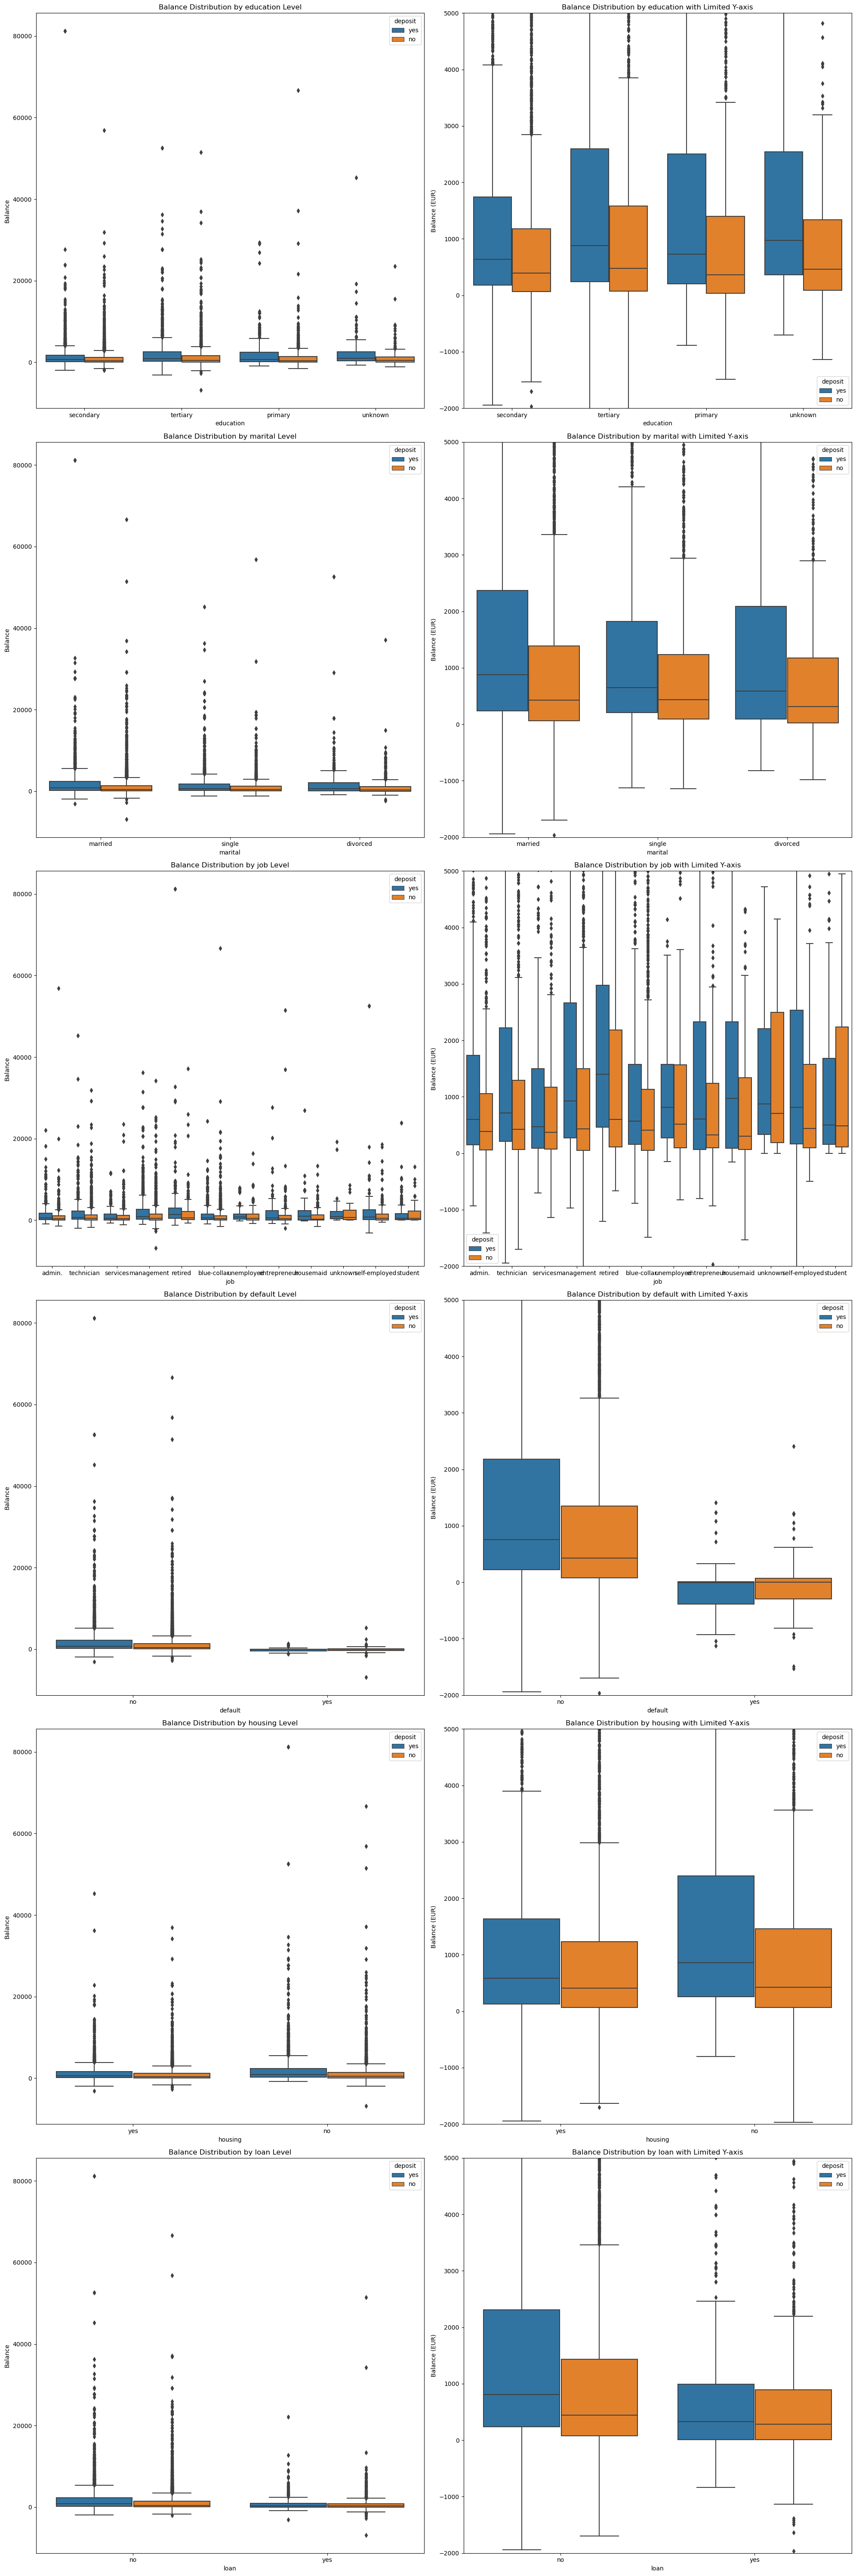

In [19]:
balance_corr_features = ['education','marital','job', 'default', 'housing', 'loan']

# Set the number of columns for the subplots
num_cols = 2
num_plots = len(balance_corr_features) * 2  # Because we are creating two plots for each feature
num_rows = (num_plots // num_cols) + (num_plots % num_cols > 0)

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10 * num_rows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for idx, f in enumerate(balance_corr_features):
    # Regular box plot
    sns.boxplot(x=f, y='balance', hue='deposit', data=df, ax=axs[idx*2])
    axs[idx*2].set_title(f'Balance Distribution by {f} Level')
    axs[idx*2].set_xlabel(f)
    axs[idx*2].set_ylabel('Balance')

    # Box plot with limited y-axis
    sns.boxplot(x=f, y='balance', hue='deposit', data=df, ax=axs[idx*2+1])
    axs[idx*2+1].set_ylim(-2000, 5000)  # Adjust limits as necessary based on your data's range
    axs[idx*2+1].set_title(f'Balance Distribution by {f} with Limited Y-axis')
    axs[idx*2+1].set_xlabel(f)
    axs[idx*2+1].set_ylabel('Balance (EUR)')

# Remove empty subplots
for j in range(len(balance_corr_features) * 2, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

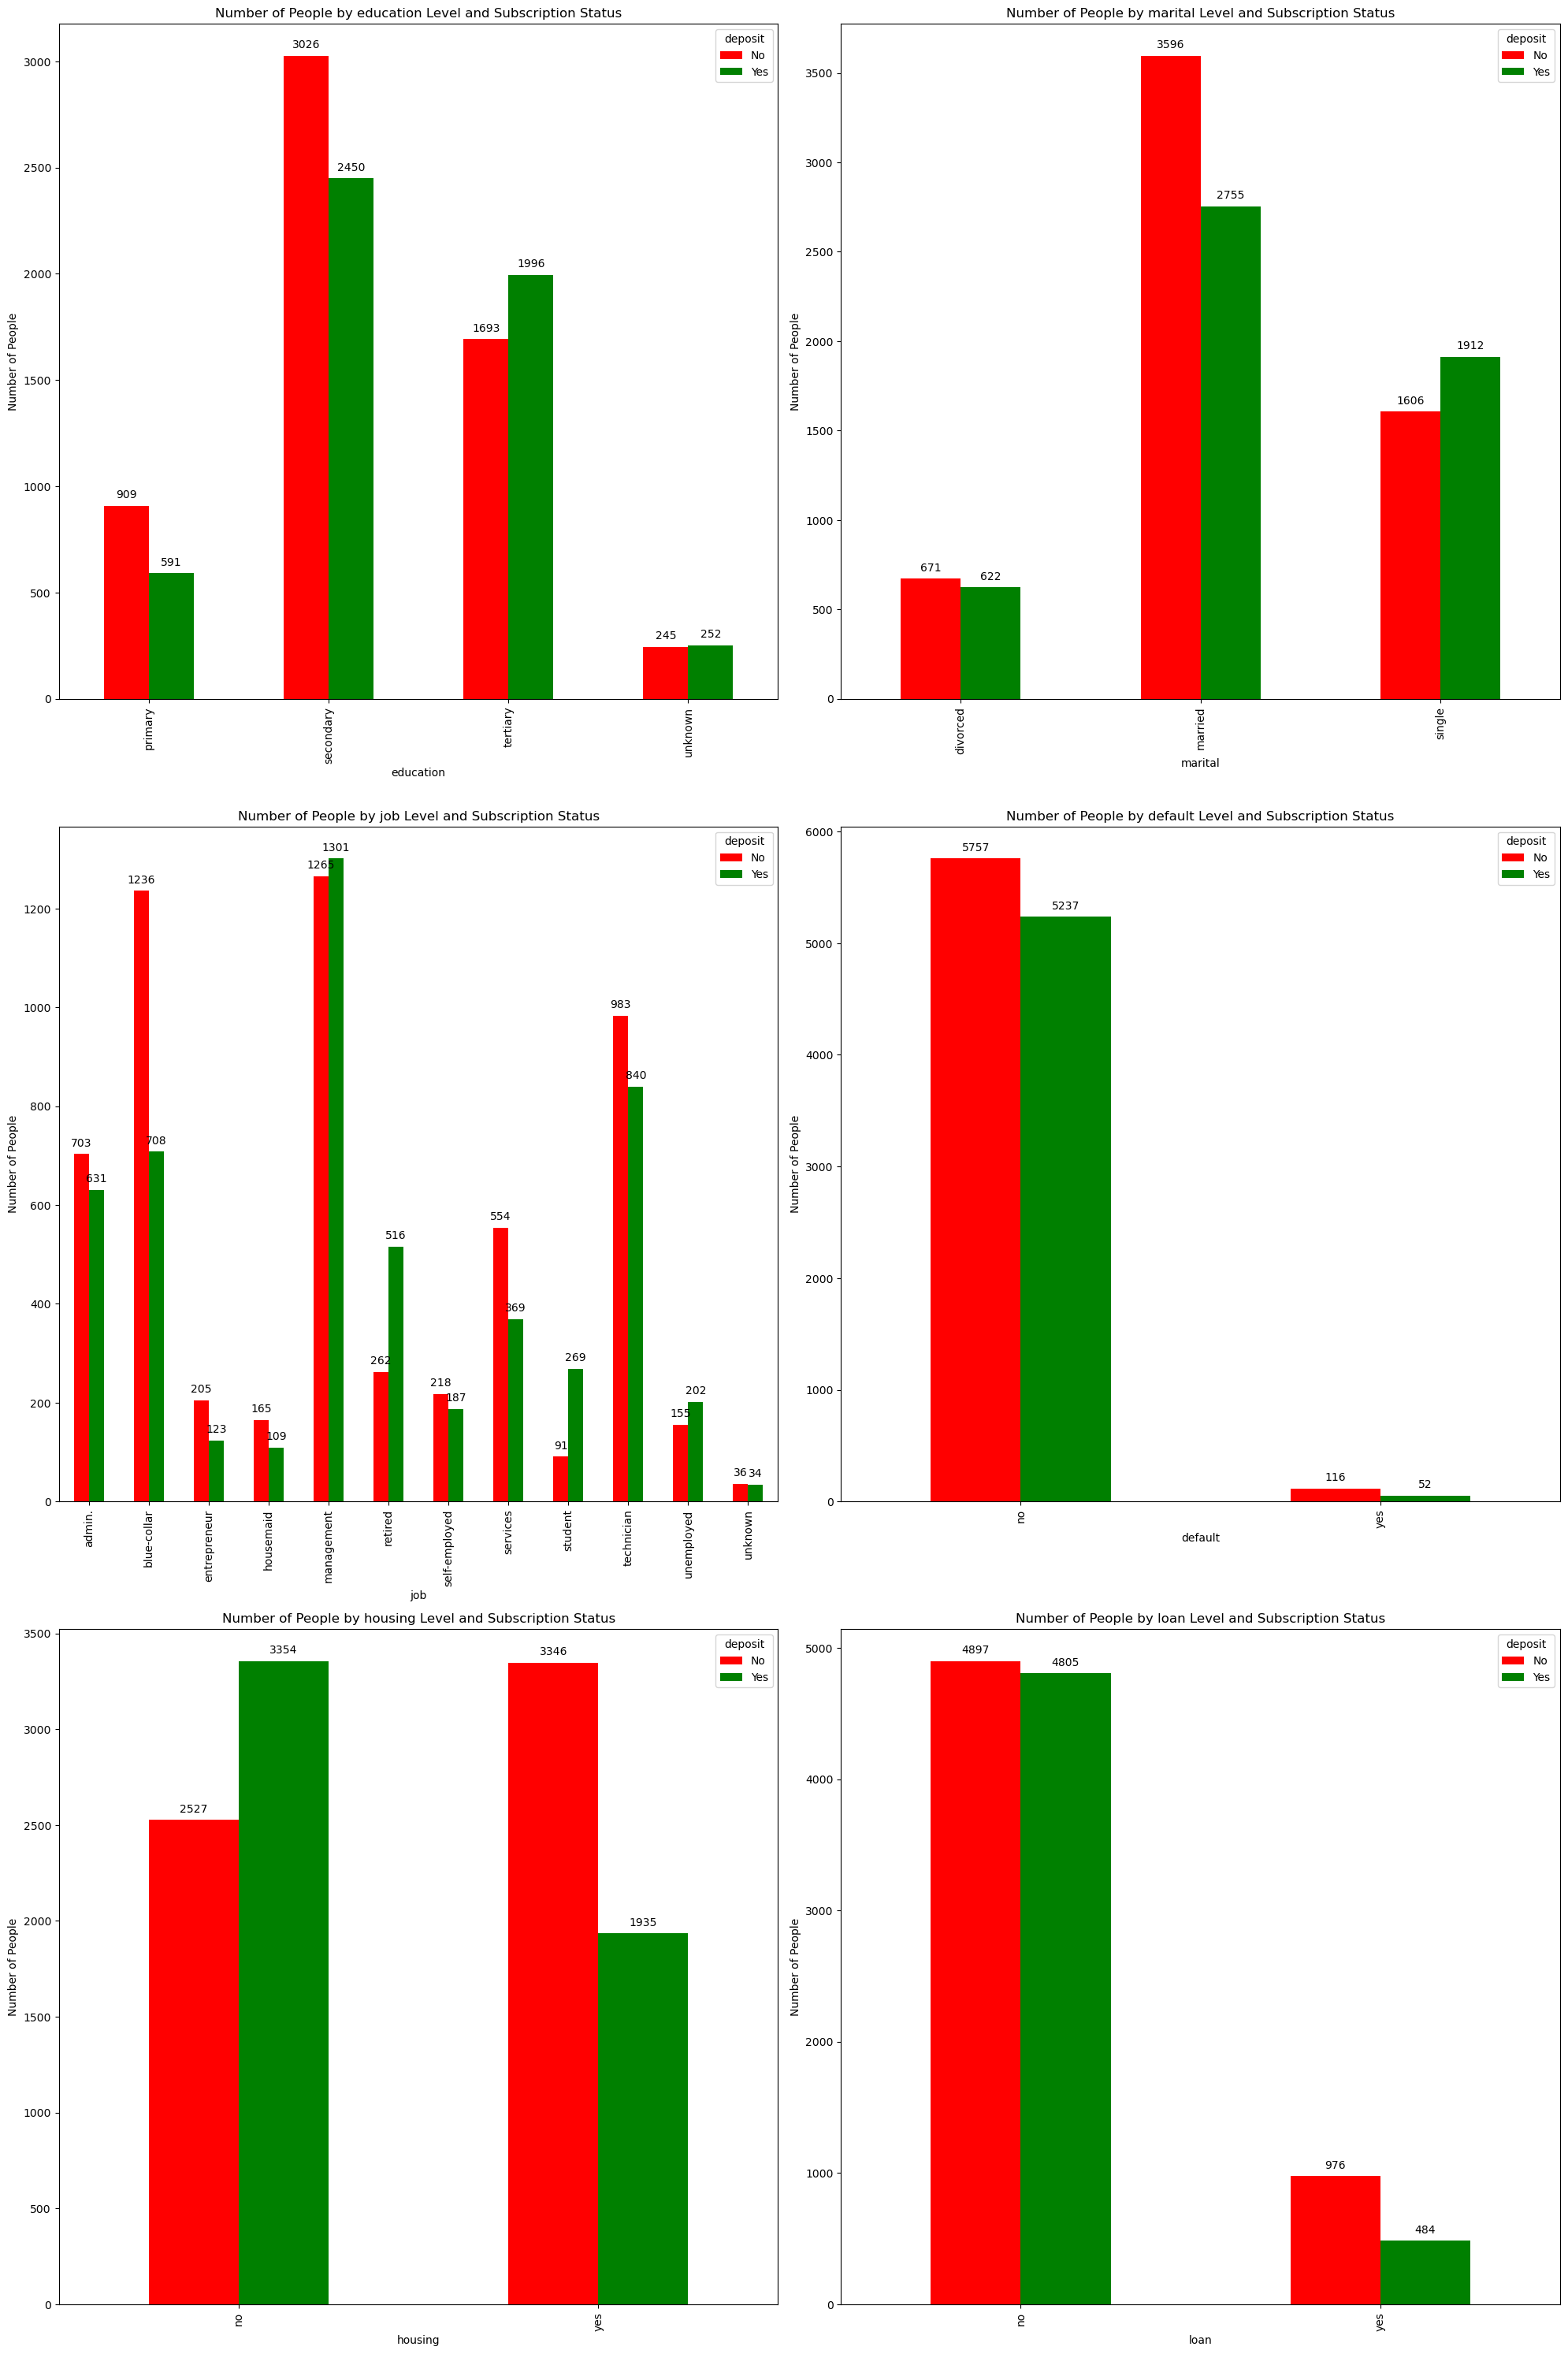

In [20]:
# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10 * num_rows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for idx, f in enumerate(balance_corr_features):
    # Calculate the counts for each category
    grouped = df.groupby([f, 'deposit']).size().unstack(fill_value=0)

    # Plotting side-by-side bar chart on the respective subplot
    ax = grouped.plot(kind='bar', color=['red', 'green'], ax=axs[idx])
    ax.set_ylabel('Number of People')
    ax.set_title(f'Number of People by {f} Level and Subscription Status')
    ax.legend(title='deposit', labels=['No', 'Yes'])

    # Annotating bars with counts
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

# Remove empty subplots
for j in range(idx + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


We can see that for all the features we have multiple outliers that most of them are above the maximum level. Iin addition, the outliers can be very high so I wanted to zoom in, in order to view the plot better. 

From these plots we can see that in general, in many categories of features, the median of people who subscribed for deposit is higher than people who didn't.
We can see that regarding the debt features (housing, loan, default, etc) those who don't have a debt and with higher balance are tend to subscribe for deposit.
In addition, the marital status also affect the balance, since married people has more income which affect the balance.

#### Feature: duration

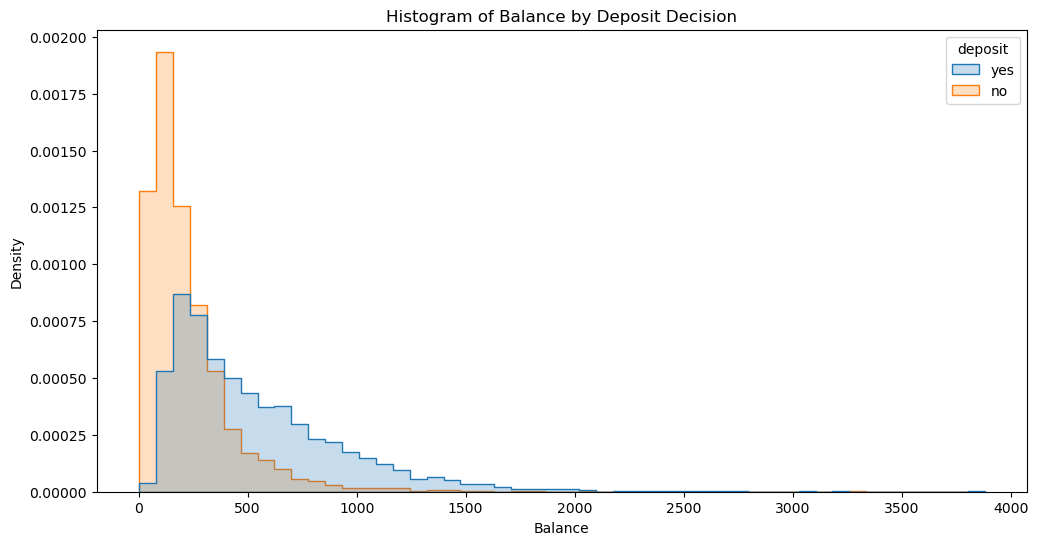

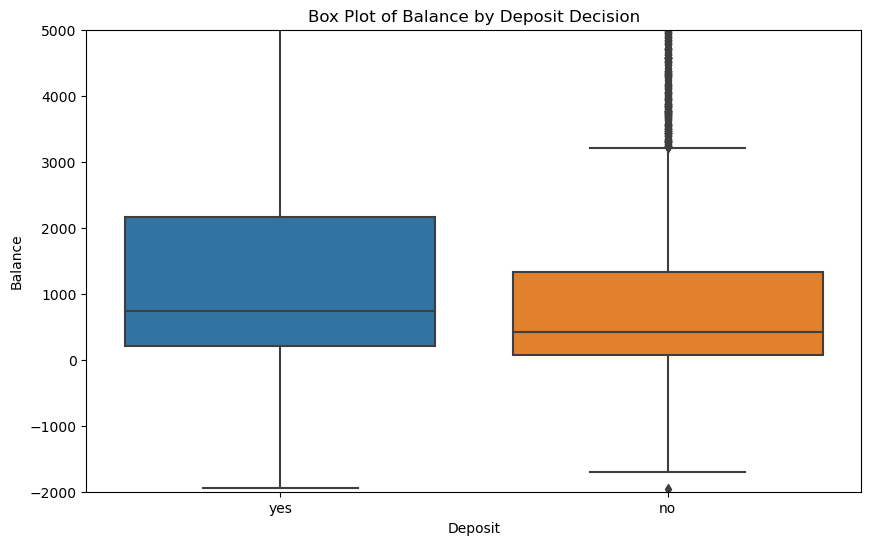

In [21]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='duration', hue='deposit', bins=50, kde=False, element='step', stat='density')
plt.xlabel('Balance')
plt.ylabel('Density')
plt.title('Histogram of Balance by Deposit Decision')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='deposit', y='balance', data=df)
plt.xlabel('Deposit')
plt.ylabel('Balance')
plt.ylim(-2000, 5000)  # Adjust limits as necessary based on your data's range
plt.title('Box Plot of Balance by Deposit Decision')
plt.show()

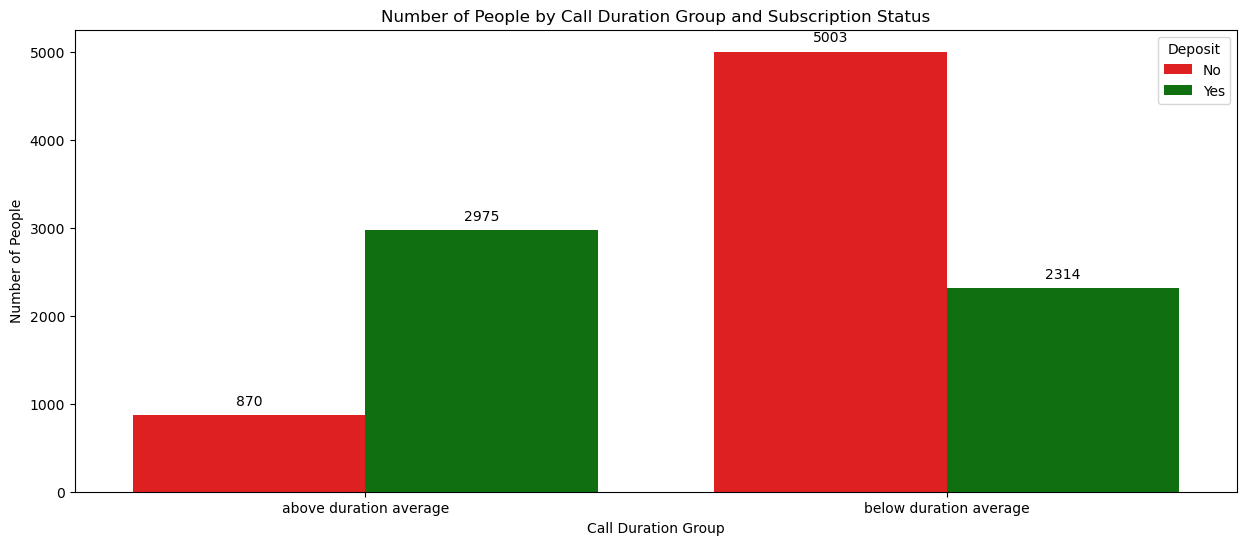

In [22]:
# Calculate the average duration
average_duration = df['duration'].mean()

# Create a new column to indicate whether duration is above or below the average
df['duration_group'] = df['duration'].apply(lambda x: 'above duration average' if x > average_duration else 'below duration average')

# Calculate the counts for each duration group and deposit status
grouped = df.groupby(['duration_group', 'deposit']).size().unstack(fill_value=0).reset_index()
grouped = grouped.melt(id_vars=['duration_group'], value_vars=['no', 'yes'], var_name='deposit', value_name='count')

# Plot side-by-side bar chart
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='duration_group', y='count', hue='deposit', data=grouped, palette=['red', 'green'])
plt.title('Number of People by Call Duration Group and Subscription Status')
plt.ylabel('Number of People')
plt.xlabel('Call Duration Group')

# Ensure the legend colors match the bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['No', 'Yes'], title='Deposit')

# Annotating bars with counts
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()

This looks very conclusive- from here it seems that the longer the call (since around 350 second~6 minutes) the more likely a person will agree for deposit.

The reason why duration is highly correlated with opening a term deposit is because the more the bank talks to a target client the higher the probability the target client will agree to term deposit since a higher duration means a higher interest (commitment) from the potential client, and this feature might be meaningful to our model.

### Features: pdays, campaign, previous

Now, let's look at the values of 'campaign', 'pdays' and 'previous' features:

In [23]:
df[['pdays', 'campaign', 'previous']].describe()

pdays      campaign      previous
count  11162.000000  11162.000000  11162.000000
mean      51.330407      2.508421      0.832557
std      108.758282      2.722077      2.292007
min       -1.000000      1.000000      0.000000
25%       -1.000000      1.000000      0.000000
50%       -1.000000      2.000000      0.000000
75%       20.750000      3.000000      1.000000
max      854.000000     63.000000     58.000000

As we can see, the standard deviation on the pdays is very large which means it is broad all over the dataset.

In [24]:
(df['pdays'] > -1).sum()/len(df)

0.25425550976527506

On pdays, -1 is 75% of the values for this column and as far as we know, it could be a noise so I think to remove this column from the dataset.
In addition, we saw that the previous has 0.5 correlation with this feature so I bleive it would be more informative and we'll keep it instead.

now let's see the campaign feature regarding vs the target by dividing it to people with 1 contact and people with more:

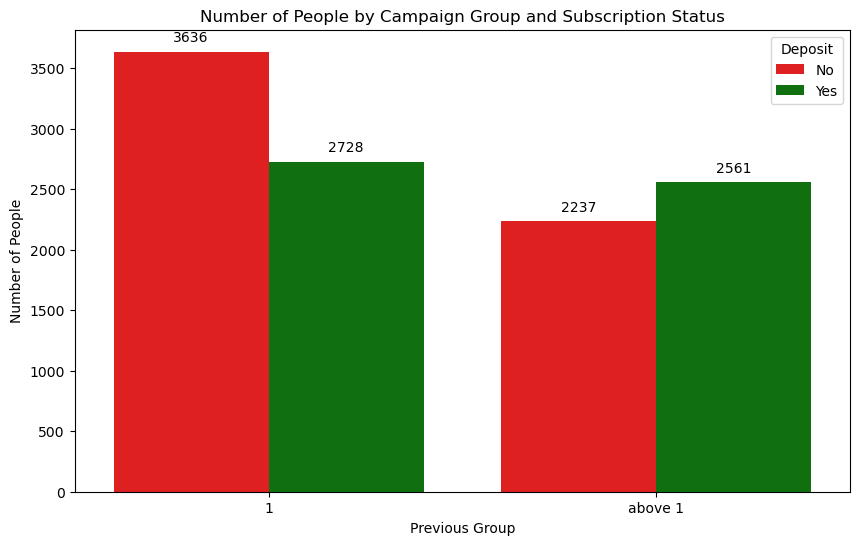

In [25]:
# Create a new column to indicate whether pdays is 0 or above 0
df['campaign_group'] = df['campaign'].apply(lambda x: 'above 1' if x == 1 else '1')

# Calculate the counts for each previous group and deposit status
grouped = df.groupby(['campaign_group', 'deposit']).size().unstack(fill_value=0).reset_index()
grouped = grouped.melt(id_vars=['campaign_group'], value_vars=['no', 'yes'], var_name='deposit', value_name='count')

# Plotting side-by-side bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='campaign_group', y='count', hue='deposit', data=grouped, palette=['red', 'green'])
plt.title('Number of People by Campaign Group and Subscription Status')
plt.ylabel('Number of People')
plt.xlabel('Previous Group')

# Ensure the legend colors match the bars and enhance legend visibility
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['No', 'Yes'], title='Deposit', loc='upper right')

# Annotating bars with counts
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()

As we can see, there's a difference between one contact call and more than 1- it can mean that people not always agree for a deposit at the first time so this feature might be important.

## categorical features analysis

First, let's see the distribution of the categorical features with the target

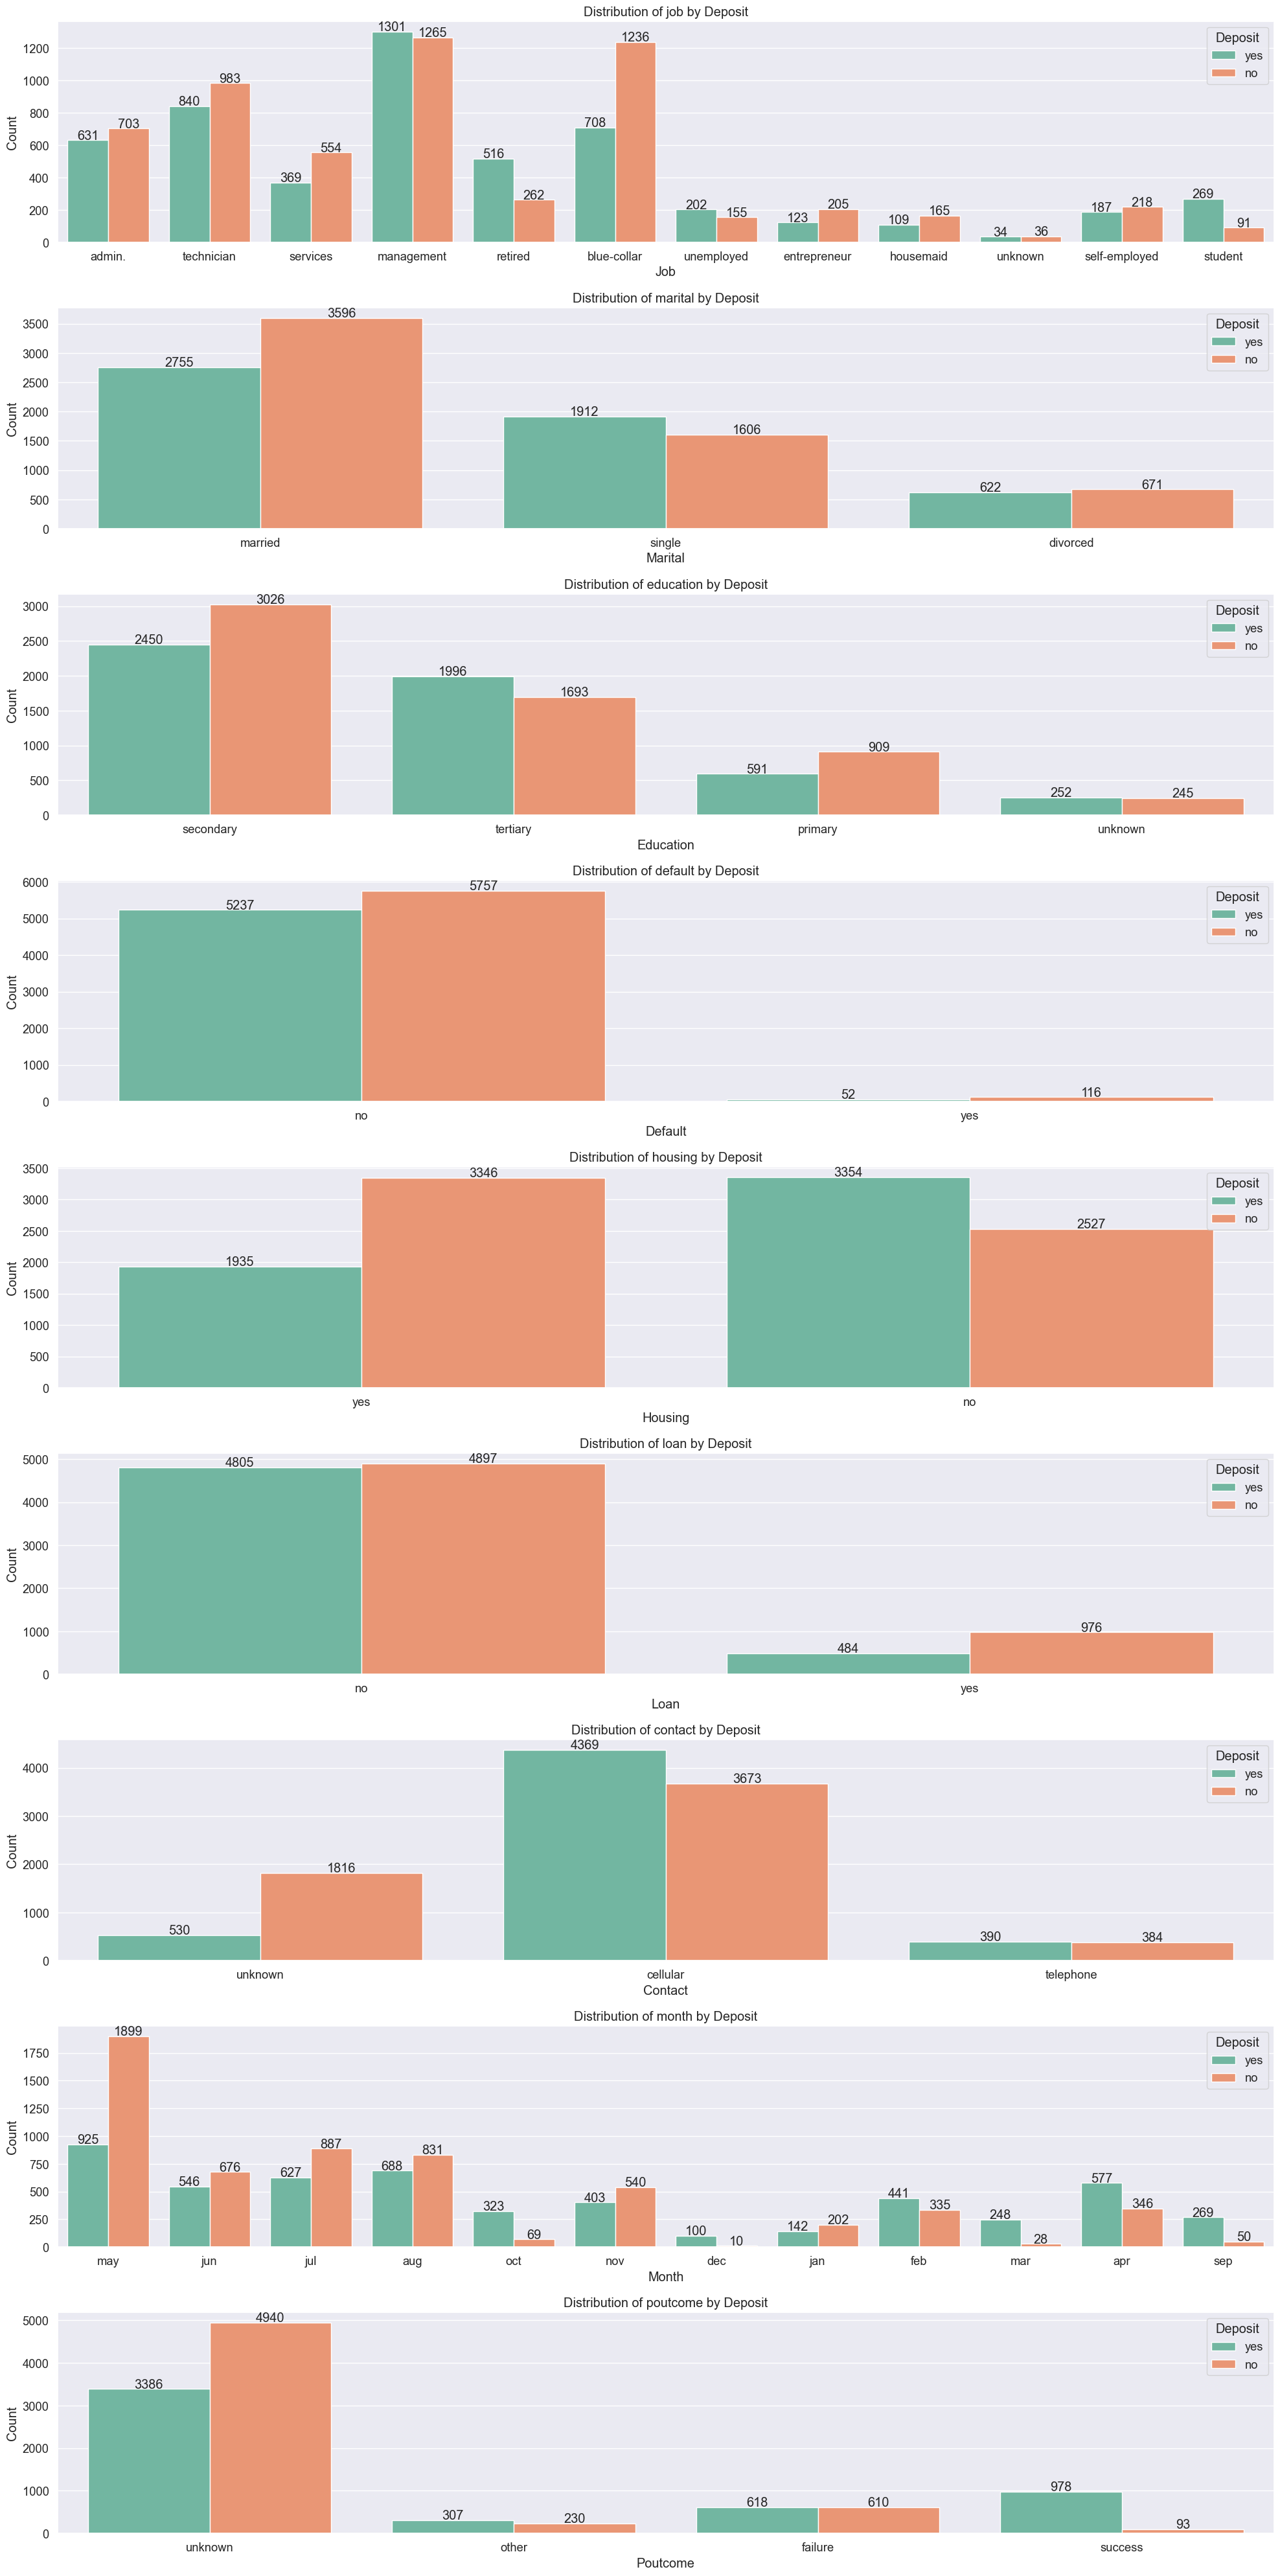

In [108]:
categorical_columns = ['job','marital','education','default','housing','loan','contact','month','poutcome']

# plot bar chart for all categorical features
# Set the size of the plots
plt.figure(figsize=(20, 40))

# Loop through the categorical columns and create a bar plot for each
for i, column in enumerate(categorical_columns):
    plt.subplot(len(categorical_columns), 1, i + 1)  # Creates a subplot for each category
    ax = sns.countplot(data=df, x=column, hue='deposit', palette='Set2')  # Creates the bar plot
    plt.title(f'Distribution of {column} by Deposit')
    plt.xlabel(column.capitalize())  # Capitalize the x-axis label
    plt.ylabel('Count')  # Set the y-axis label
    plt.legend(title='Deposit', loc='upper right')  # Add legend with title
    
    # Annotate the bars with their counts
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),  # Format the count as an integer
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # Position for the text
                    ha = 'center', va = 'center',  # Center alignment
                    xytext = (0, 5),  # 5 points vertical offset
                    textcoords = 'offset points')

plt.tight_layout()
plt.show()

Some initial insights from the plot, and features that can get give us some interesting insights:
1. It can be seen that more married people agree to the deposit but it can be seen that among the singles, the probability of agreeing to the deposit is higher, even though fewer singles than married were sampled. I also assume that divorced people have less money since they have more expenses separately (alimony, rent/mortgage) and this may affect their consent to the deposit. Of course, there are other factors that can affect these results.
2. As can be seen, education may also have an effect on the chance of agreeing to a deposit. I believe that education has an effect on a person's income or salary and therefore also on their bank balance. Therefore, I think that education has an effect on the chance of agreeing to the deposit and of course we will look into it later as well.
3. I noticed that if people have a loan on the house, they will be less inclined to take a deposit and vice versa. In addition, most of the people sampled for the default feature were people without default on their credit. This makes sense because people who have defaulted on their credit are more limited in their account so there is no reason to offer them a deposit in the first place. The same goes for the loan feature - those who have a loan probably want to pay back the loan and don't have enough free money for a deposit.

#### Features: job, marital, education, default, housing, loan, contact?

#### Features: Job & education

Let's review the distribution of jobs with the education level education:

In [28]:
pd.crosstab(df['job'], df['education'])

education      primary  secondary  tertiary  unknown
job                                                 
admin.              42       1084       168       40
blue-collar        694       1116        48       86
entrepreneur        41        141       132       14
housemaid          144         78        43        9
management          66        238      2178       84
retired            277        314       140       47
self-employed       28        136       230       11
services            83        746        53       41
student             21        189        83       67
technician          41       1209       521       52
unemployed          56        210        84        7
unknown              7         15         9       39

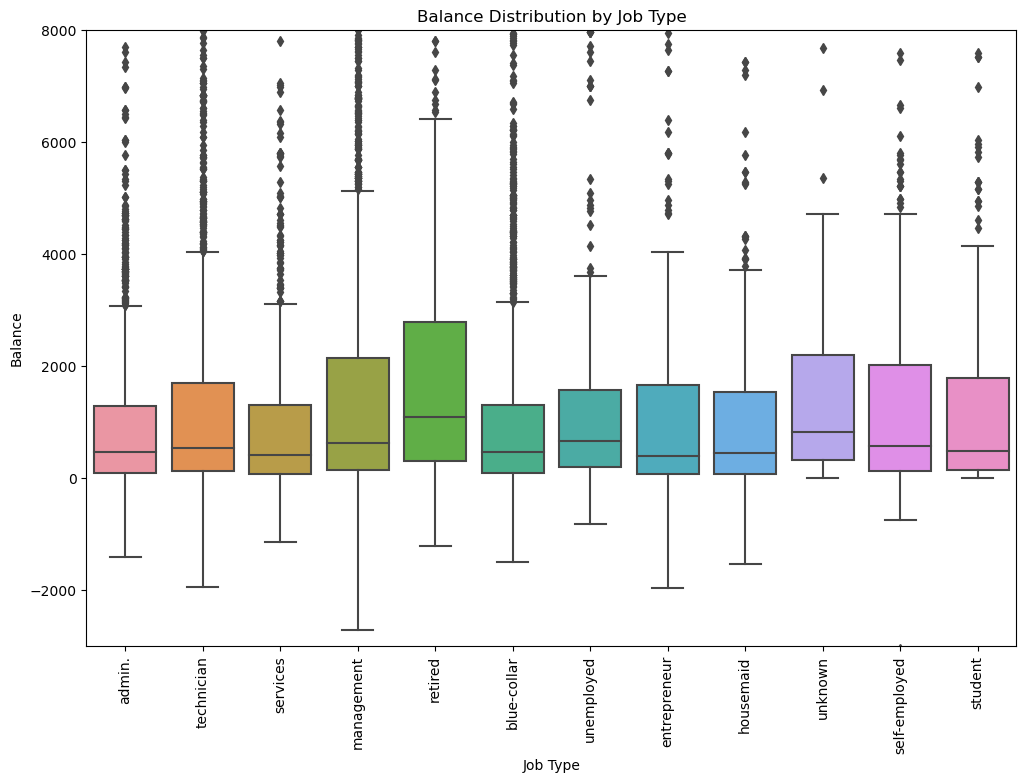

In [29]:
# Box plot for job vs. balance
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='job', y='balance')
plt.xticks(rotation=90)
plt.ylim(-3000, 8000) 
plt.title('Balance Distribution by Job Type')
plt.xlabel('Job Type')
plt.ylabel('Balance')
plt.show()

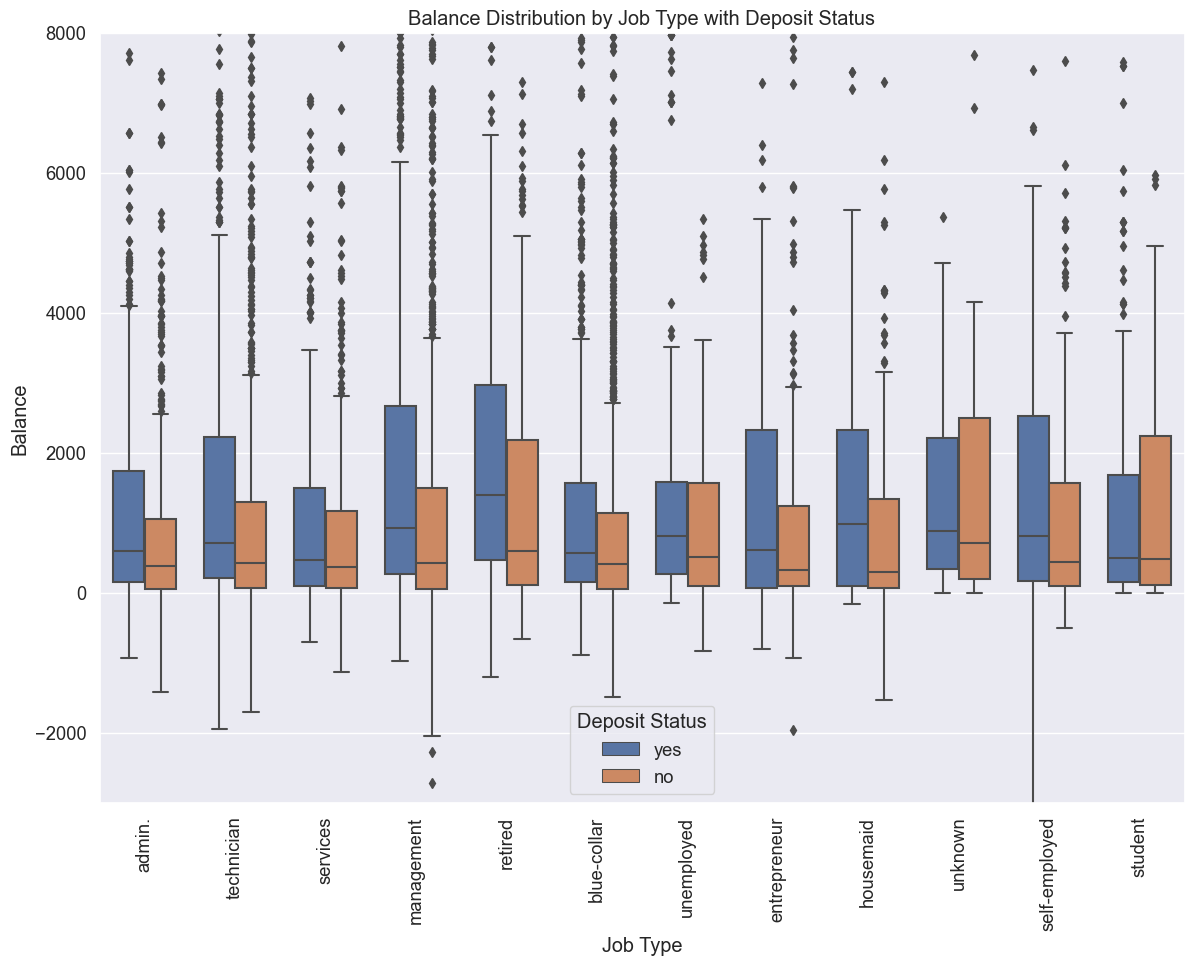

In [30]:
# Box plot for job vs. balance with deposit status
plt.figure(figsize=(14, 10))
sns.set(font_scale=1.2)  # Increase font size
sns.boxplot(data=df, x='job', y='balance', hue='deposit', width=0.7, fliersize=5)  # Increase box width and outlier size
plt.xticks(rotation=90)
plt.title('Balance Distribution by Job Type with Deposit Status')
plt.xlabel('Job Type')
plt.ylabel('Balance')
plt.ylim(-3000, 8000) 
plt.legend(title='Deposit Status')
plt.show()

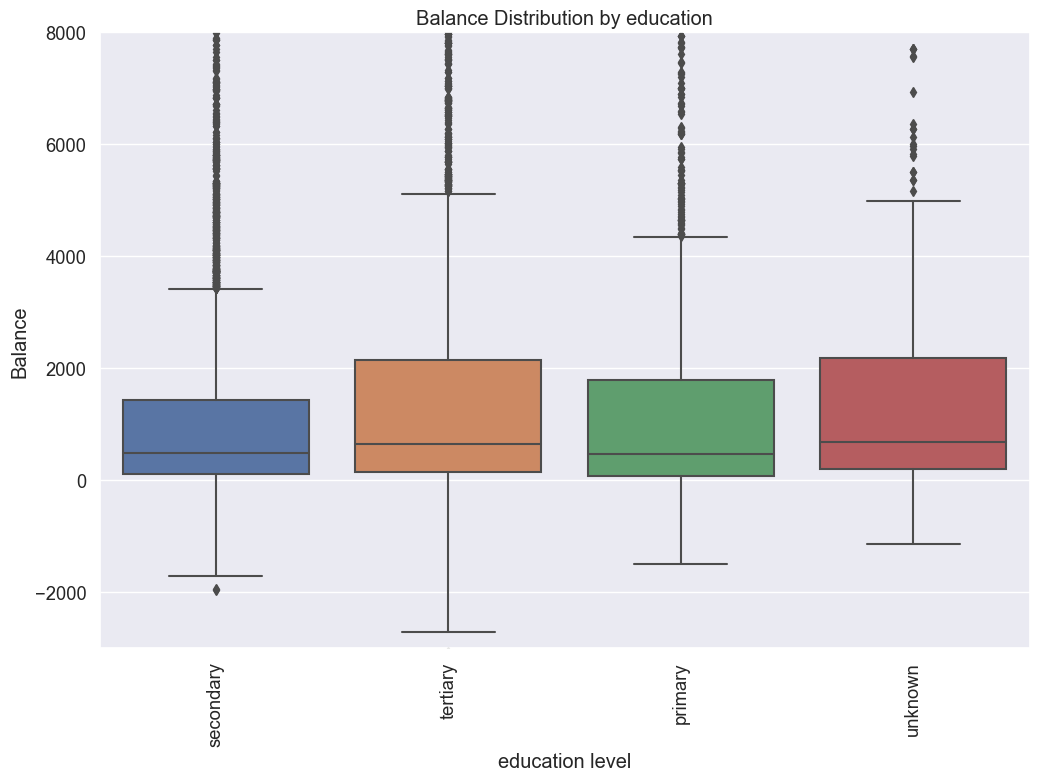

In [31]:
# Box plot for education vs. balance
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='education', y='balance')
plt.xticks(rotation=90)
plt.ylim(-3000, 8000) 
plt.title('Balance Distribution by education')
plt.xlabel('education level')
plt.ylabel('Balance')
plt.show()

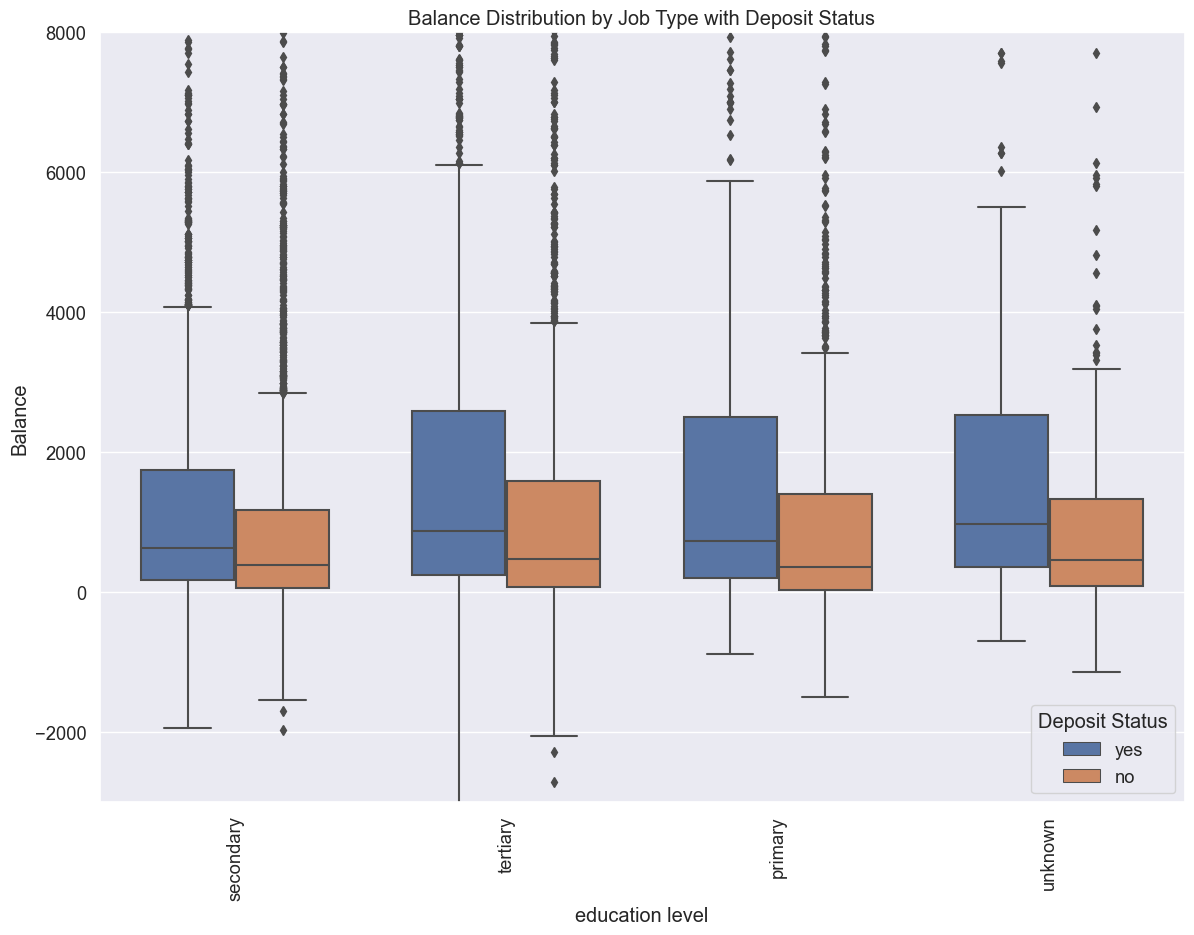

In [32]:
# Box plot for job vs. balance with deposit status
plt.figure(figsize=(14, 10))
sns.set(font_scale=1.2)  # Increase font size
sns.boxplot(data=df, x='education', y='balance', hue='deposit', width=0.7, fliersize=5)  # Increase box width and outlier size
plt.xticks(rotation=90)
plt.title('Balance Distribution by Job Type with Deposit Status')
plt.xlabel('education level')
plt.ylabel('Balance')
plt.ylim(-3000, 8000) 
plt.legend(title='Deposit Status')
plt.show()

We saw before that the most likely jobs that have positive ratio to subscribe for deposit are mainly management and retired people, and in the education level we have tertiary level, and that not that much.
since the age of retired people has also positive ratio to subscribe for the deposit it makes sense.
people with higher education can be more financial educated, so they could understand better the benefits of a deposit reather people who are not with that education level (not necessarily, but it is possible).
In addition, we can see that the mean of the managers and retired people is higher than the rest of the categories, and that around 85% of the managers has tertiary education and around 20% from all the people that has been sampled are managers with tertiary education, which can point of the level of income and the probability to agree for a deposit. 

#### Feature: marital

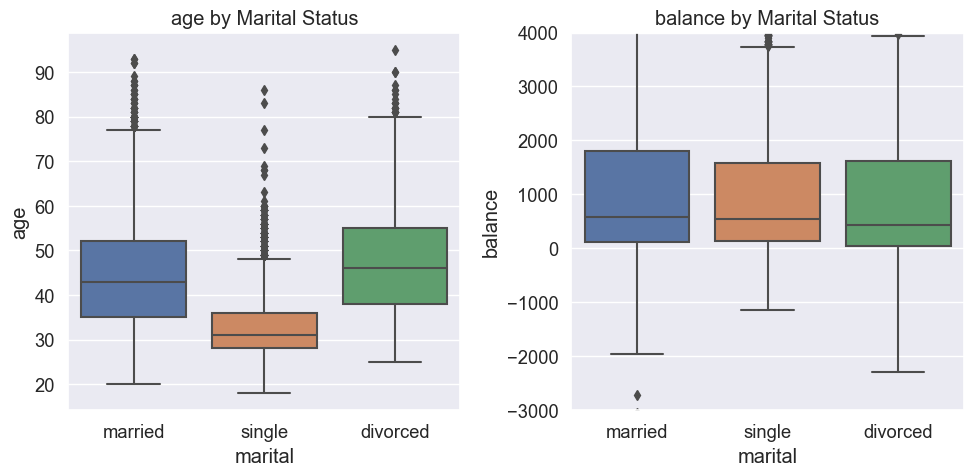

In [33]:
numerical_features = ['age', 'balance']

# Set the number of plots per row
plots_per_row = 3

# Calculate number of rows needed
num_rows = (len(numerical_features) + plots_per_row - 1) // plots_per_row

# Create a figure with subplots
plt.figure(figsize=(15, num_rows * 5))  # Adjust the size as needed

# Loop through the numerical features and create a box plot for each
for index, feature in enumerate(numerical_features):
    plt.subplot(num_rows, plots_per_row, index + 1)
    if index==1:
          plt.ylim(-3000, 4000) 
    sns.boxplot(x='marital', y=feature, data=df)
    plt.title(f'{feature} by Marital Status')

# Adjust layout
plt.tight_layout()
plt.show()

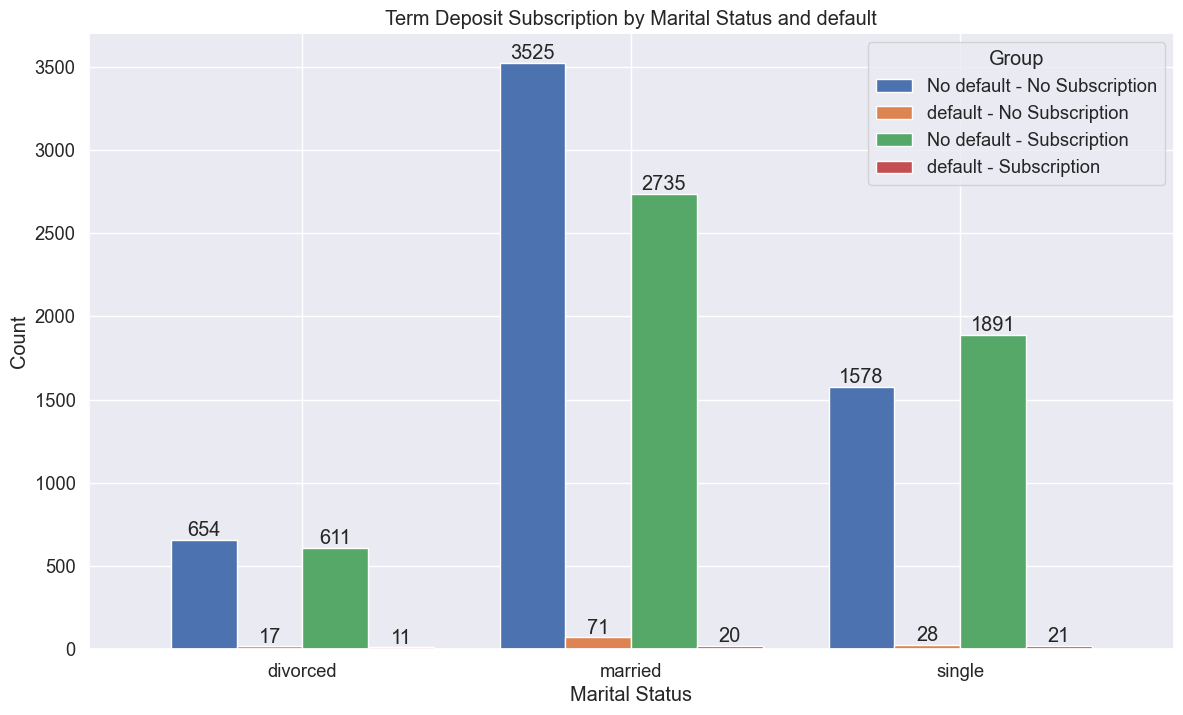

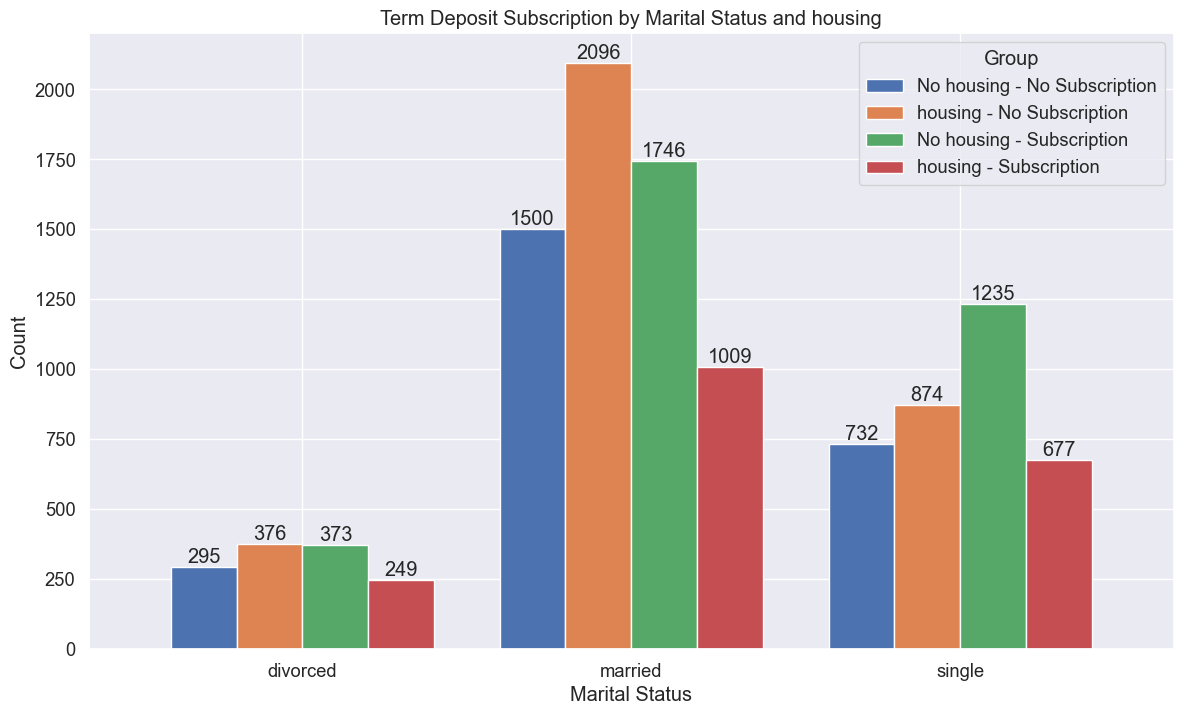

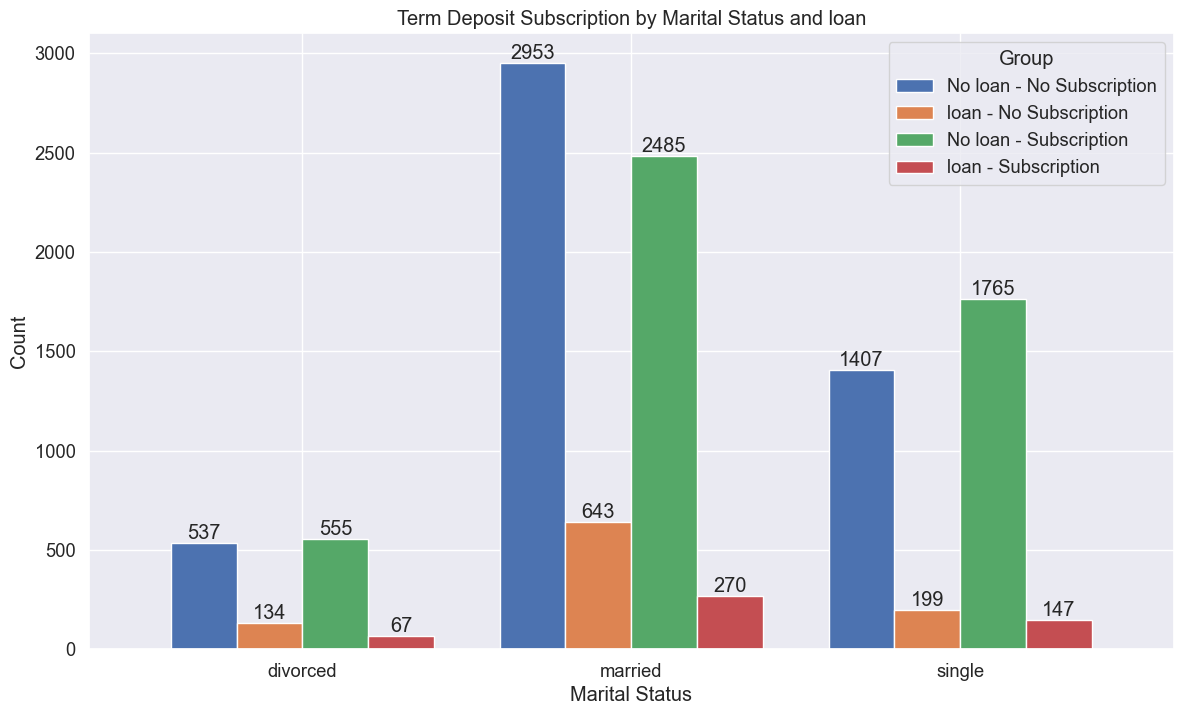

In [34]:
loans_features = ['default','housing','loan']

for feature in loans_features:

    # Group by marital status, default status, and target variable
    grouped = df.groupby(['marital',feature, 'deposit']).size().unstack(fill_value=0).unstack(fill_value=0)

    # Flatten the multi-index columns for ease of plotting
    grouped.columns = [f"{col1}_{col2}" for col1, col2 in grouped.columns]

    # Plotting
    ax = grouped.plot(kind='bar', figsize=(14, 8), width=0.8)

    # Add text annotations
    for container in ax.containers:
        ax.bar_label(container, label_type='edge')

    # Set labels and title
    plt.xlabel('Marital Status')
    plt.ylabel('Count')
    plt.title(f'Term Deposit Subscription by Marital Status and {feature}')
    plt.xticks(rotation=0)

    # Set legend
    plt.legend(title='Group', labels=[
        f'No {feature} - No Subscription', f'{feature} - No Subscription', 
        f'No {feature} - Subscription', f'{feature} - Subscription'
    ])

    # Show plot
    plt.show()

We can see that it is mostly married people who has been targeted to the deposit campaign.
In addition, we can see that there isn't a distinctive gap between the balance distribution regarding the marital status, and the age distribution of single is smaller than divored or married.
I can deduce from the bar plots that most of the people that has been sampled has no deposit or loans. moreover, the amount of people who agreed/disagreed to deposit is pretty same in general for these 2 features.
However, we can see in general that single people are more likely to subscribe to a banking deposit if they don't have any debt and the opposite. this can be explained by the reason that single people allow themself to "give up" money when they feel in more secure banking status.
Married people tend not to take a deposit in total regardless on the loan. this can be also explain if they have a mortgage or they plan to invest their money in more profitable saving programs.
Therefore, even though more married people has been sampled, I believe that this feature might contribute to the model, mostly because of the single sampled after all.

#### Features: default, housing, loan

Explanation about dafault feature: **Defaulting on your credit card means you've failed to make at least the minimum payment for 180 days.**

As it has been seen above, there's a more likely to subscribe for deposit when people don't have a house loan and the opposite.
On default and loan features, there's almost 50-50 chance to subscribe to deposit when don't have neither and and less likely to subscribe when people have one of those debts. 

Let's see if these features overlap each other:

##### default vs hosuing

In [35]:
# Group by each pair of features and count the occurrences
identical_rows_default_housing = df.groupby(['default', 'housing']).size().reset_index(name='count')
identical_rows_default_housing

default housing  count
0      no      no   5800
1      no     yes   5194
2     yes      no     81
3     yes     yes     87

In [36]:
identical_rows_default_housing_target = df.groupby(['default', 'housing', 'deposit']).size().reset_index(name='count')

# Pivot the table to get counts for 'yes' and 'no' deposits separately
pivot_table = identical_rows_default_housing_target.pivot_table(index=['default', 'housing'], columns='deposit', values='count', fill_value=0).reset_index()

# Calculate the probabilities
pivot_table['probability_deposit'] = pivot_table['yes'] / (pivot_table['yes'] + pivot_table['no']) * 100

# Display the result
summary_table = pivot_table[['default', 'housing', 'probability_deposit']]
print(identical_rows_default_housing_target)
print(summary_table)

  default housing deposit  count
0      no      no      no   2469
1      no      no     yes   3331
2      no     yes      no   3288
3      no     yes     yes   1906
4     yes      no      no     58
5     yes      no     yes     23
6     yes     yes      no     58
7     yes     yes     yes     29
deposit default housing  probability_deposit
0            no      no            57.431034
1            no     yes            36.696188
2           yes      no            28.395062
3           yes     yes            33.333333


We can see that for given people without a default, if the a person don't have a house loan there's 57% to subscribe for deposit, where if a person have also a house loan, the probability to subscribe for deposit is 37%. It might show that the combination of these 2 features has indication on the target.

##### default vs loan

In [37]:
identical_rows_default_loan = df.groupby(['default', 'loan']).size().reset_index(name='count')
identical_rows_default_loan

default loan  count
0      no   no   9591
1      no  yes   1403
2     yes   no    111
3     yes  yes     57

In [38]:
identical_rows_default_loan_target = df.groupby(['default', 'loan','deposit']).size().reset_index(name='count')

# Pivot the table to get counts for 'yes' and 'no' deposits separately
pivot_table = identical_rows_default_loan_target.pivot_table(index=['default', 'loan'], columns='deposit', values='count', fill_value=0).reset_index()

# Calculate the probabilities
pivot_table['probability_deposit'] = pivot_table['yes'] / (pivot_table['yes'] + pivot_table['no']) * 100

# Display the result
summary_table = pivot_table[['default', 'loan', 'probability_deposit']]
print(identical_rows_default_loan_target)
print(summary_table)

  default loan deposit  count
0      no   no      no   4823
1      no   no     yes   4768
2      no  yes      no    934
3      no  yes     yes    469
4     yes   no      no     74
5     yes   no     yes     37
6     yes  yes      no     42
7     yes  yes     yes     15
deposit default loan  probability_deposit
0            no   no            49.713273
1            no  yes            33.428368
2           yes   no            33.333333
3           yes  yes            26.315789


Here we see that the doesn't having a loan and without deposit is higher when there's no default but thre'es a loan. 
the combination of both might have an impact on the target.

##### housing vs loan

In [39]:
identical_rows_housing_loan = df.groupby(['housing', 'loan']).size().reset_index(name='count')
identical_rows_housing_loan

housing loan  count
0      no   no   5256
1      no  yes    625
2     yes   no   4446
3     yes  yes    835

In [40]:
identical_rows_housing_loan_target = df.groupby(['housing', 'loan','deposit']).size().reset_index(name='count')

# Pivot the table to get counts for 'yes' and 'no' deposits separately
pivot_table = identical_rows_housing_loan_target.pivot_table(index=['housing', 'loan'], columns='deposit', values='count', fill_value=0).reset_index()

# Calculate the probabilities
pivot_table['probability_deposit'] = pivot_table['yes'] / (pivot_table['yes'] + pivot_table['no']) * 100

# Display the result
summary_table = pivot_table[['housing', 'loan', 'probability_deposit']]
print(identical_rows_housing_loan_target)
print(summary_table)

  housing loan deposit  count
0      no   no      no   2121
1      no   no     yes   3135
2      no  yes      no    406
3      no  yes     yes    219
4     yes   no      no   2776
5     yes   no     yes   1670
6     yes  yes      no    570
7     yes  yes     yes    265
deposit housing loan  probability_deposit
0            no   no            59.646119
1            no  yes            35.040000
2           yes   no            37.561853
3           yes  yes            31.736527


We see here that the deposit rate has 60% chance to subscribe to deposit when the're is no loans, and it drops around 25-29% when there's at least one more loan. 

In [41]:
identical_rows_with_target = df.groupby(['default', 'housing', 'loan', 'deposit']).size().reset_index(name='count')


# Pivot the table to get counts for 'yes' and 'no' deposits separately
pivot_table = identical_rows_with_target.pivot_table(index=['default', 'housing', 'loan'], columns='deposit', values='count', fill_value=0).reset_index()

# Calculate the probabilities
pivot_table['probability_deposit'] = pivot_table['yes'] / (pivot_table['yes'] + pivot_table['no']) * 100

# Display the result
summary_table = pivot_table[['default', 'housing', 'loan', 'probability_deposit']]
print(identical_rows_with_target)
print(summary_table)

   default housing loan deposit  count
0       no      no   no      no   2089
1       no      no   no     yes   3120
2       no      no  yes      no    380
3       no      no  yes     yes    211
4       no     yes   no      no   2734
5       no     yes   no     yes   1648
6       no     yes  yes      no    554
7       no     yes  yes     yes    258
8      yes      no   no      no     32
9      yes      no   no     yes     15
10     yes      no  yes      no     26
11     yes      no  yes     yes      8
12     yes     yes   no      no     42
13     yes     yes   no     yes     22
14     yes     yes  yes      no     16
15     yes     yes  yes     yes      7
deposit default housing loan  probability_deposit
0            no      no   no            59.896333
1            no      no  yes            35.702200
2            no     yes   no            37.608398
3            no     yes  yes            31.773399
4           yes      no   no            31.914894
5           yes      no  yes         

Again, a drop down in the probability to agree subscribe to a deposit when there's at least on loan/debt.

**Summary:** 

we see that all the 3 features doesn't overlap each other.
As we seen before, the distribution of the balnce regarding these 3 features indicates that there is a signficance wether a person has kind of debt to his balance, and people that agree to deposit without a debt tends to have higher balance, and it is very significant. this might indicate for more campaign on future to focus on these kind of people.
Regarding the connection between these 3 features, we see that when it is involving at least one debt/loan, a person chances to agree for deposit is droping signicficaly.
I didn't see any difference that the default feature is making (except maybe with the balance, there we could see the balance difference as well), it seems not to have a diffrent impact cs the target or with other features as well, so I think to remove it from the model.
Since we're not looking only on the positive cases, I would like to keep both housing & the features, since we can see connections of these features for both to subscribe/unsubscribe to deposit and we see the difference between them with other features as well.

#### Feature: job

As we seen before, the job can have an impact on the balance and the of a person and it can affect the debt features as we seen before.
Therefore I believe it would be a userful feature in our model.

In [42]:
df = df.drop(columns=['deposit_numeric','balance_group','duration_group','campaign_group'])

### Feature Selection

As I wrote above, I'll remove the default and pdays columns and keep the age group feature that I created before

In [43]:
df = df.drop(columns=['default','pdays'])

### Feature engineering

#### Scaling
Since we have multiple outliers in many numeric features, we'll use **Standardization** in this case, in order to decrease the influence of the outliers on the model, because we're taking into account standard deviation.
If there was not many outliers as we seen before, a good method was normalization too.

#### Categorical features encoding
since the order isn't matter on all the features except for education, we'll use **one hot encoding**.
In addition, we'll encode education on one hot encoding, since we have an unknown category that appears multiple times.
also, for yes/no column values, we'll convert them to binary columns as well.

In [44]:
# Define the categorical, binary and numerical features
# Identify categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Identify binary features by checking for 2 unique values
binary_features = [col for col in df.columns if df[col].nunique() == 2]

# Remove binary features from categorical features list
categorical_features = [col for col in categorical_features if col not in binary_features]

# Identify numerical features
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

In [45]:
# Apply one-hot encoding to categorical features
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Encode binary features
binary_mapping = {'yes': 1, 'no': 0, 'under 60': 0, '60 or older': 1}  # Adjust as necessary
for feature in binary_features:
    df_encoded[feature] = df_encoded[feature].map(binary_mapping)

# Standardize numerical features
scaler = StandardScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

In [46]:
df_encoded

age   balance  housing  loan       day  duration  campaign  \
0      1.491505  0.252525        1     0 -1.265746  1.930226 -0.554168   
1      1.239676 -0.459974        0     0 -1.265746  3.154612 -0.554168   
2     -0.019470 -0.080160        1     0 -1.265746  2.929901 -0.554168   
3      1.155733  0.293762        1     0 -1.265746  0.596366 -0.554168   
4      1.071790 -0.416876        0     0 -1.265746  0.867171 -0.186785   
...         ...       ...      ...   ...       ...       ...       ...   
11157 -0.691015 -0.473616        1     0  0.515650 -0.331287 -0.554168   
11158 -0.187357 -0.246658        0     0  0.040612 -0.832564  0.547981   
11159 -0.774958 -0.464934        0     0  0.396891 -0.622258 -0.186785   
11160  0.148416 -0.473926        0     1 -0.909466 -1.045752 -0.186785   
11161 -0.607072 -0.473926        0     0 -0.790707  0.737530 -0.554168   

       previous  deposit  above_60  ...  month_jul  month_jun  month_mar  \
0     -0.363260        1         0  ...          0          0          0   
1     -0.363260        1         0  ...          0          0          0   
2     -0.363260        1         0  ...          0          0          0   
3     -0.363260        1         0  ...          0          0          0   
4     -0.363260        1         0  ...          0          0          0   
...         ...      ...       ...  ...        ...        ...        ...   
11157 -0.363260        0         0  ...          0          0          0   
11158 -0.363260        0         0  ...          0          1          0   
11159 -0.363260        0         0  ...          0          0          0   
11160  1.818332        0         0  ...          0          0          0   
11161 -0.363260        0         0  ...          1          0          0   

       month_may  month_nov  month_oct  month_sep  poutcome_other  \
0              1          0          0          0               0   
1              1          0          0          0               0   
2              1          0          0          0               0   
3              1          0          0          0               0   
4              1          0          0          0               0   
...          ...        ...        ...        ...             ...   
11157          0          0          0          0               0   
11158          0          0          0          0               0   
11159          0          0          0          0               0   
11160          1          0          0          0               0   
11161          0          0          0          0               0   

       poutcome_success  poutcome_unknown  
0                     0                 1  
1                     0                 1  
2                     0                 1  
3                     0                 1  
4                     0                 1  
...                 ...               ...  
11157                 0                 1  
11158                 0                 1  
11159                 0                 1  
11160                 0                 0  
11161                 0                 1  

[11162 rows x 42 columns]

### Modeling 

now let's use several models that are known for **high predictive performance: XGBoost, LightGBM, Gradient Boosting, Random Forest and Decision Tree**. We will utilize grid search to find the optimal hyperparameters for each model.

Let's talk about overfitting. **Overfitting is an error in the modeling algorithm that takes into consideration random noise in the fitting process rather than the pattern itself**. You can see that this occurs when the model gets an awsome score in the training set but when we use the test set (Unknown data for the model) we get an awful score. This is likely to happen because of overfitting of the data (taking into consideration random noise in our pattern). What we want our model to do is to take the overall pattern of the data in order to correctly classify whether a potential client will suscribe to a term deposit or not. for example, if the accuracy on the train set is very high and on the test set is very low, we'll know that we have overfitting.

**The best alternative to avoid overfitting is to use cross validation**. Taking the training test and splitting it. For instance, if we split it by 3, 2/3 of the data or 66% will be used for training and 1/3 33% will be used or testing and we will do the testing process three times. This algorithm will iterate through all the training and test sets and the main purpose of this is to grab the overall pattern of the data. There are multiple methods for cross validation: Hold-out (Simple Train-Test Split),
K-folds etc. We'll use K-folds in our case.

In [47]:
# Split your data into features and target
X = df_encoded.drop('deposit', axis=1)
y = df_encoded['deposit']

In [71]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# Apply k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

In [92]:
param_grids = {
    'random_forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'decision_tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'xgboost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6]
    },
    'gradient_boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'lightgbm': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100]
    }
}

In [93]:
models = {
    'random_forest': RandomForestClassifier(),
    'decision_tree': DecisionTreeClassifier(),
    'xgboost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'gradient_boosting': GradientBoostingClassifier(),
    'lightgbm': lgb.LGBMClassifier()
}

In [94]:
# Perform grid search for each model
best_models = {}
results = []
best_models = {}

for model_name in models:
    print(f"Performing grid search for {model_name}...")
    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=kf, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_cross_val_score = grid_search.best_score_
    test_score = best_model.score(X_test, y_test)
    results.append({
        'Model': model_name,
        'Best Cross-Val Score': best_cross_val_score,
        'Test Score': test_score
    })
    best_models[model_name] = best_model
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {best_cross_val_score}")
    print(f"Test score for {model_name}: {test_score}")

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

Performing grid search for random_forest...
Best parameters for random_forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation score for random_forest: 0.8570946766164471
Test score for random_forest: 0.8414688759516346
Performing grid search for decision_tree...
Best parameters for decision_tree: {'max_depth': 10, 'min_samples_split': 2}
Best cross-validation score for decision_tree: 0.8173370221548865
Test score for decision_tree: 0.8132557098074339
Performing grid search for xgboost...
Best parameters for xgboost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best cross-validation score for xgboost: 0.8642626591510065
Test score for xgboost: 0.8446036721898791
Performing grid search for gradient_boosting...
Best parameters for gradient_boosting: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
Best cross-validation score for gradient_boosting: 0.8597826857506721
Test score for gradient_boosting: 0.8446036721898791
Perfo

In [95]:
results_df

Model  Best Cross-Val Score  Test Score
0      random_forest              0.857095    0.841469
1      decision_tree              0.817337    0.813256
2            xgboost              0.864263    0.844604
3  gradient_boosting              0.859783    0.844604
4           lightgbm              0.863254    0.849530

As we can see, the accuracy is not very different between the test and train sets for all the algorithms, so there's no overfitting.
It seems on first sight that the best models are lightgbm and xgboost.
W'ell take a look over the confusion matrix and other methods to check models too. 

### Confisuion Matrix 

The main purpose of a confusion matrix is to see how our model is performing when it comes to classifying potential clients that are likely to suscribe to a term deposit. We will see in the confusion matrix four terms the True Positives, False Positives, True Negatives and False Negatives.


**Positive/Negative**: Type of Class (label) ["No", "Yes"] **True/False**: Correctly or Incorrectly classified by the model.


**True Negatives (Top-Left Square)**: This is the number of **correctly** classifications of the "No" class or potenial clients that are **not willing** to suscribe a term deposit.


**False Negatives (Top-Right Square)**: This is the number of **incorrectly** classifications of the "No" class or potential clients that are not **willing** to suscribe a term depositt.


**False Positives (Bottom-Left Square)**: This is the number of **incorrectly** classifications of the "Yes" class or potential clients that are **willing** to suscribe a term deposit.


**True Positives (Bottom-Right Square)**: This is the number of **correctly** classifications of the "Yes" class or potenial clients that are **willing** to suscribe a term deposit.

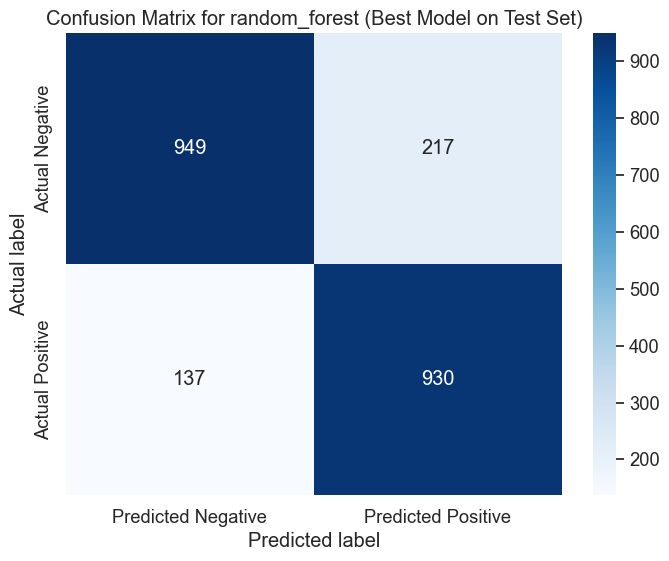

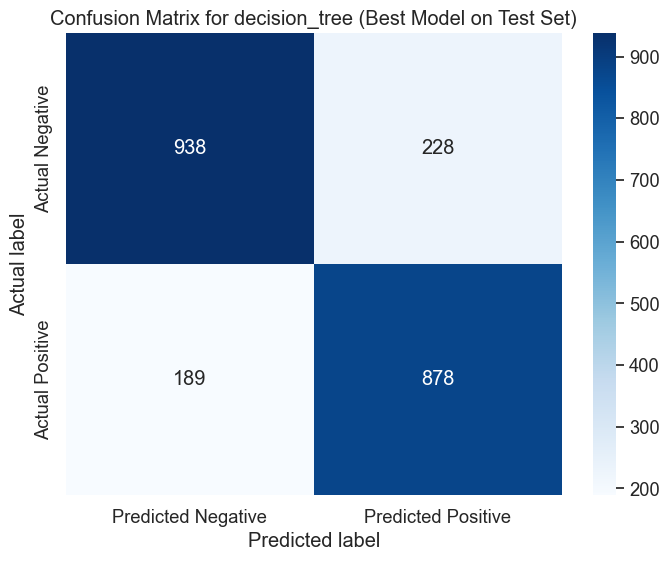

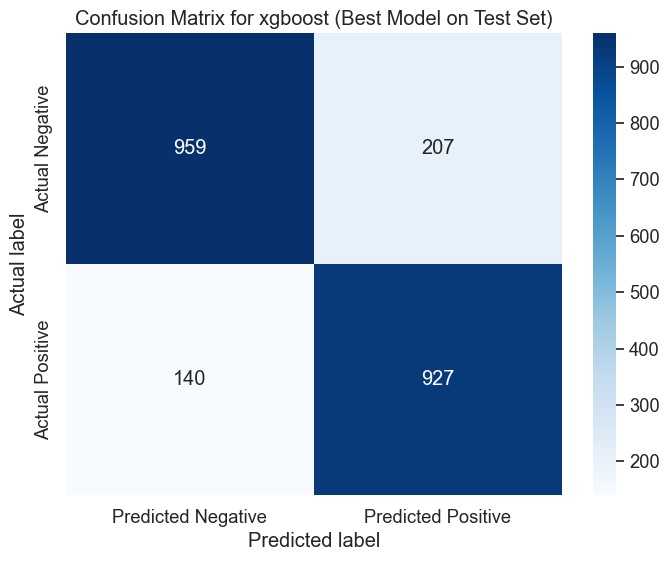

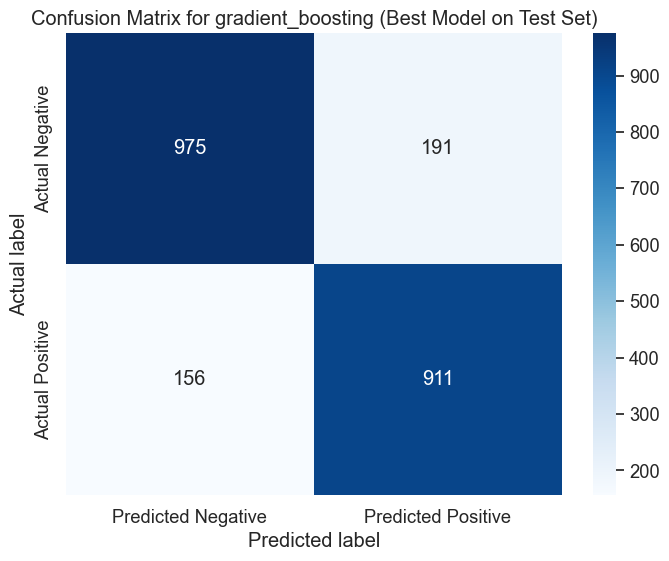

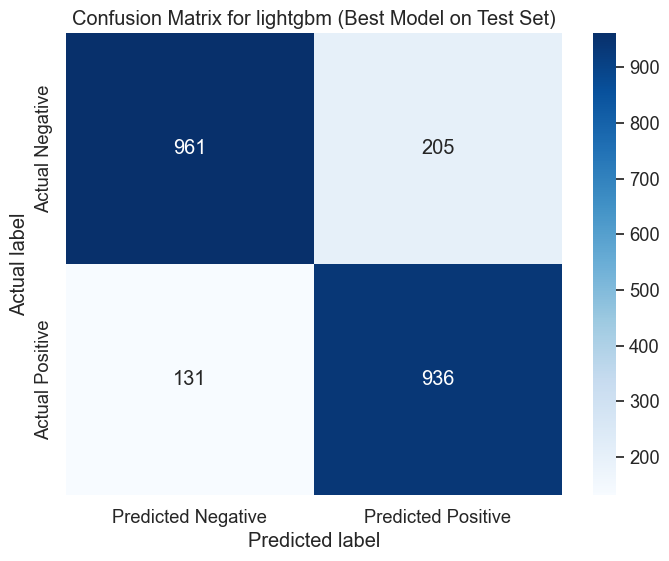

In [96]:
# Calculate metrics for each model using the test set
precisions = []
recalls = []
f1_scores = []

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Plot confusion matrix for the test set
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix for {model_name} (Best Model on Test Set)')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

# Add metrics to the results DataFrame
results_df['Precision'] = precisions
results_df['Recall'] = recalls
results_df['F1 Score'] = f1_scores

#### Precision, Recall & F1

Now we'll use **precision, recall and f1** measures to meassure our mode'l accuracy. These metrics are used to evaluate the accuracy of a classification model.
They should be calculated on the test dataset to get an unbiased assessment of the model's performance. Evaluating these metrics on the training data would not reflect the model's ability to generalize to new, unseen data.

**Precision**: Means how sure is the prediction of our model that the actual label is a "Yes". The formula to calculate it is: TP/(TP+FP)

**Recall**: Is the total number of "Yes" in the label column of the dataset. So how many "Yes" labels does our model detect. The formula to calculate it is: TP/(TP+FN)

**F1**: a combintation of both precision and recall.

**Recall Precision Tradeoff**:
As the precision gets higher the recall gets lower and vice versa. For instance, if we increase the precision from 30% to 60% the model is picking the predictions that the model believes is 60% sure. If there is an instance where the model believes that is 58% likely to be a potential client that will suscribe to a term deposit then the model will classify it as a "No." However, that instance was actually a "Yes" (potential client did suscribe to a term deposit.) That is why the higher the precision the more likely the model is to miss instances that are actually a "Yes"!

In [97]:
results_df

Model  Best Cross-Val Score  Test Score  Precision    Recall  \
0      random_forest              0.857095    0.841469   0.810811  0.871603   
1      decision_tree              0.817337    0.813256   0.793852  0.822868   
2            xgboost              0.864263    0.844604   0.817460  0.868791   
3  gradient_boosting              0.859783    0.844604   0.826679  0.853796   
4           lightgbm              0.863254    0.849530   0.820333  0.877226   

   F1 Score  
0  0.840108  
1  0.808099  
2  0.842344  
3  0.840018  
4  0.847826

We will discuss these results during the metric results discussion

### ROC Curve (Receiver Operating Characteristic):

The ROC curve tells us how well our classifier is classifying between term deposit suscriptions (True Positives) and non-term deposit suscriptions. The X-axis is represented by False positive rates (Specificity) and the Y-axis is represented by the True Positive Rate (Sensitivity). As the line moves the threshold of the classification changes giving us different values. The closer is the line to our top right corner the better is our model separating both classes.

This curve is used to evaluate the performance of a classification model at various threshold settings. **The higher the ROC curve for a model, the better it is and therefore, the larger the area under the curve, the better the classifier is.**

Another note: If the dataset was imbalanced, I would prefer to use precision-recall call instead, but since it is balanced we can use the ROC curve.

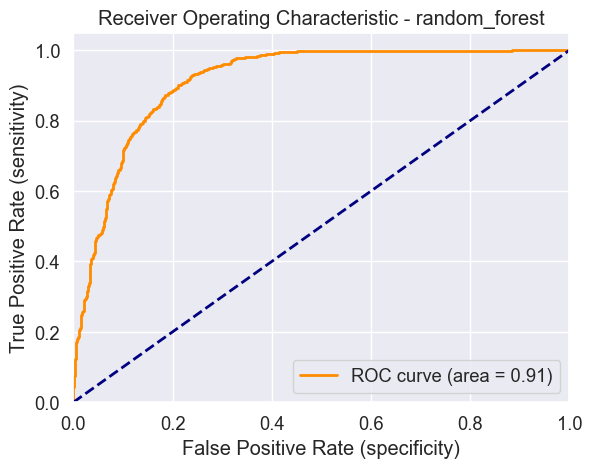

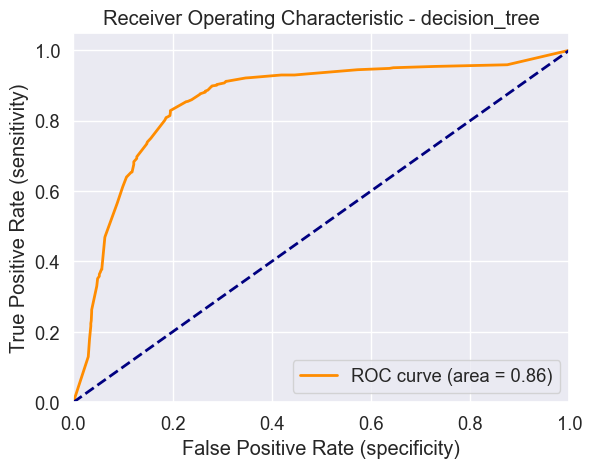

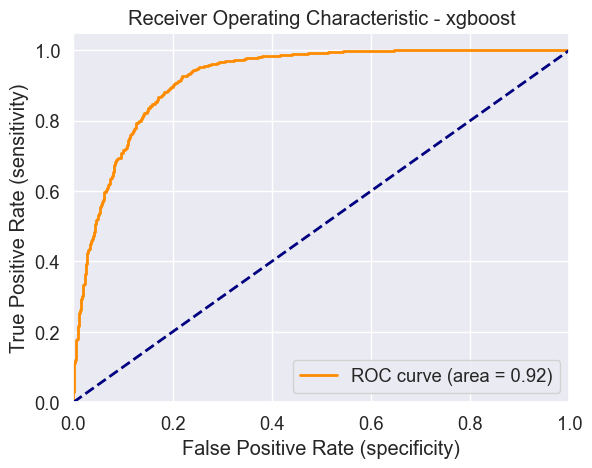

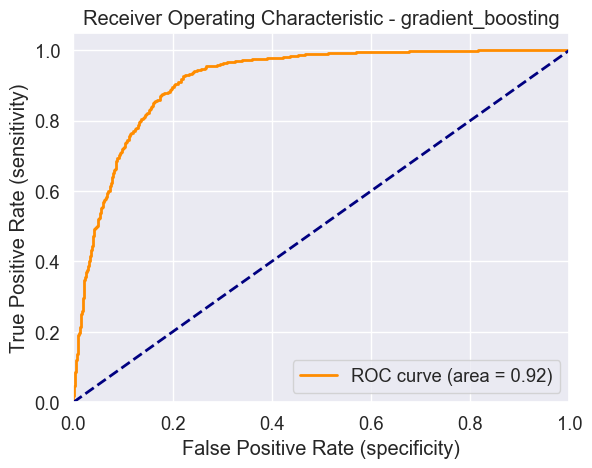

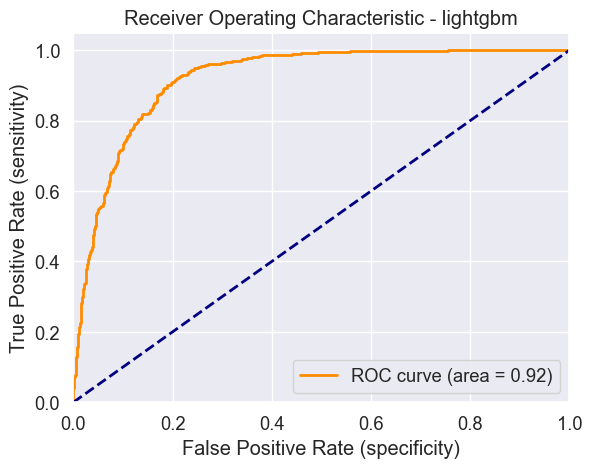

In [98]:
# Plot all ROC curves
roc_aucs = []

for model_name, model in best_models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (specificity)')
    plt.ylabel('True Positive Rate (sensitivity)')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Add metrics to the results DataFrame
results_df['ROC AUC'] = roc_aucs

In [99]:
results_df

Model  Best Cross-Val Score  Test Score  Precision    Recall  \
0      random_forest              0.857095    0.841469   0.810811  0.871603   
1      decision_tree              0.817337    0.813256   0.793852  0.822868   
2            xgboost              0.864263    0.844604   0.817460  0.868791   
3  gradient_boosting              0.859783    0.844604   0.826679  0.853796   
4           lightgbm              0.863254    0.849530   0.820333  0.877226   

   F1 Score   ROC AUC  
0  0.840108  0.914492  
1  0.808099  0.856680  
2  0.842344  0.921272  
3  0.840018  0.917053  
4  0.847826  0.921766

#### summary: we can see that lightgbm is the highest among almost all the metrics between all models  with accuracy=84.95% and AUC=92.17%!

now, let's plot the feature importance by lightGBM:

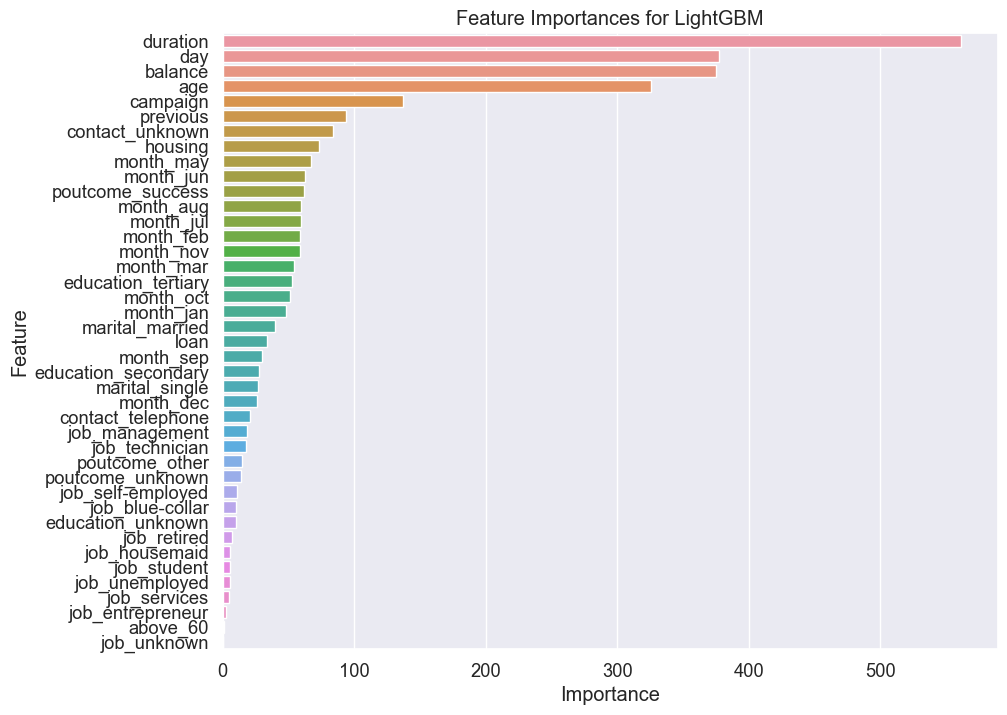

In [104]:
# Feature importance for LightGBM
best_lgbm = best_models['lightgbm']
lgbm_importances = best_lgbm.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': lgbm_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances for LightGBM')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

As we can see, the top 5 important features for this classofier are: duration, day, balance, age, campaign.
We can understand that these features conributes a lot and as we expected that the duration, balance, age and even campaign will affect the model performance. 

The conclusions that we can deduce for the results are:

* **Customers of greater age are more likely to subscribe for the term deposit.**
* **Customers with greater account balance are more likely to subscribe for the term deposit.**
* **Customers that had more than 1 contact during the campaign might be more likely to subscribe for the term deposit.**